# COMP551 Winter2020 Mini-project 2 Group24

Eric Shen 260798146<br/>
Hong Kun Tian 260866355<br/>
Suzy Liu 260761416


Preamble imports


In [0]:
import os
import re
import glob
import tarfile
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

from scipy.stats import uniform
from scipy.stats import randint

%matplotlib inline
sns.set(style='whitegrid')

SEED = 551

## Preprocess

### 20 newsgroups

In [0]:
from sklearn.datasets import fetch_20newsgroups

In [0]:
# I set training set as handout says
newsgroups_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=SEED, remove=[('headers','footers','quotes')])
newsgroups_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=SEED, remove=[('headers','footers','quotes')])

In [0]:
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [0]:
len(newsgroups_train.data)

11314

In [0]:
len(newsgroups_train.filenames)

11314

In [0]:
le = LabelEncoder()
le.fit(newsgroups_train.target_names)

LabelEncoder()

Check class distribution in both training and test sets

In [0]:
news_train_df = pd.DataFrame(le.inverse_transform(newsgroups_train.target), columns=['classes'])
news_test_df = pd.DataFrame(le.inverse_transform(newsgroups_test.target), columns=['classes'])

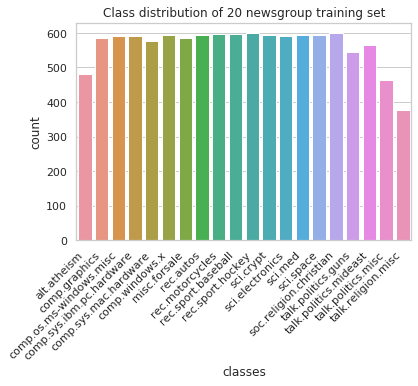

In [0]:
ax = sns.countplot(x='classes', data=news_train_df, order=newsgroups_train.target_names)
ax.set_title("Class distribution of 20 newsgroup training set")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, horizontalalignment='right')
plt.show()

#### Tf-idf term weighing

(can extract the term frequencies betwen the 2 steps)



Testing some feature selection

In [0]:
count_vect = CountVectorizer()
news_X_train_counts = count_vect.fit_transform(newsgroups_train.data)
news_X_test_counts = count_vect.transform(newsgroups_test.data)
print(news_X_train_counts.shape)
print(news_X_test_counts.shape)

(11314, 130107)
(7532, 130107)


In [0]:
count_vect.vocabulary_.get(u'algorithm')

27366

In [0]:
tfidf_transformer = TfidfTransformer()
news_X_train_tfidf = tfidf_transformer.fit_transform(news_X_train_counts)
news_X_test_tfidf = tfidf_transformer.transform(news_X_test_counts)
print(news_X_train_tfidf.shape)
print(news_X_test_tfidf.shape)

(11314, 130107)
(7532, 130107)


Normalize

In [0]:
# normalizer_train = Normalizer()
# news_X_train_tfidf = normalizer_train.fit_transform(news_X_train_tfidf)
# news_X_test_tfidf = normalizer_train.transform(news_X_test_tfidf)

Tf-idf term weighing - TfidfVectorizer (all in one step)

We decided against using this simpler method here, since we wanted to access the term frequencies and perhaps inspect the data. We will use this later for feature selection.


In [0]:
# news_tf_idf_vectorizer = TfidfVectorizer()
# news_vectors_train_idf = news_tf_idf_vectorizer.fit_transform(newsgroups_train.data)
# news_vectors_test_idf = news_tf_idf_vectorizer.transform(newsgroups_test.data)

### IMDB Reviews

Download IMDB dataset

In [0]:
if os.path.isdir('aclImdb'):
    print("Dataset directory exists")
else:    
    if not os.path.isfile('aclImdb_v1.tar.gz'):
        print("Downloading IMDB reviews dataset")
        !wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    else:
        print("Dataset already downloaded")
    
    print("Uncompress dataset")
    !tar -xf aclImdb_v1.tar.gz
    print("Dataset uncompressed in aclImdb")

Dataset directory exists


Load content from text files into numpy arrays for training and test splits

In [0]:
def load_content_from_file(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text and remove html tags
    text = re.sub('<[^>]*>', ' ', file.read())
    # close the file
    file.close()
    return text

In [0]:
positive_reviews_train = [load_content_from_file(filename) for filename in glob.glob(os.path.join('aclImdb/train/pos', "*.txt"))]
negative_reviews_train = [load_content_from_file(filename) for filename in glob.glob(os.path.join('aclImdb/train/neg', "*.txt"))]
positive_reviews_test = [load_content_from_file(filename) for filename in glob.glob(os.path.join('aclImdb/test/pos', "*.txt"))]
negative_reviews_test = [load_content_from_file(filename) for filename in glob.glob(os.path.join('aclImdb/test/neg', "*.txt"))]

Check class distribution in both training and test sets

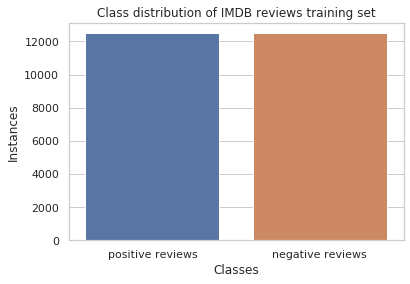

In [0]:
ax = sns.barplot(["positive reviews", "negative reviews"], [len(positive_reviews_train), len(negative_reviews_train)])
ax.set_title("Class distribution of IMDB reviews training set")
ax.set_xlabel("Classes")
ax.set_ylabel("Instances")

plt.show()

In [0]:
imdb_X_train = np.array(positive_reviews_train + negative_reviews_train)
imdb_y_train = np.array([1] * len(positive_reviews_train) + [0] * len(negative_reviews_train))

imdb_X_test = np.array(positive_reviews_test + negative_reviews_test)
imdb_y_test = np.array([1] * len(positive_reviews_test) + [0] * len(negative_reviews_test))

In [0]:
shuffle(imdb_X_train, imdb_y_train, random_state=SEED)
shuffle(imdb_X_test, imdb_y_test, random_state=SEED)

[array(['This is a well directed Columbo episode, with also some good character but the story just doesn\'t really know to interest enough and doesn\'t appear as well layered and constructed as was often the case with a Columbo movie. This also goes for the killer\'s plot to kill his uncle. It\'s quite simple and doesn\'t seem as well thought out. Perhaps this movie didn\'t really took itself serious enough, since the atmosphere of the movie is mostly light. At least when compared to different Columbo movies.  For instance the movie features quite a large amount of comical relief, mostly coming from the Columbo character himself. It makes the movie an enjoyable one to watch but it also gives you the feeling they sort of overdid it times, also mostly since it doesn\'t correspond with most other Columbo movies.  The characters are good and it helps that it features Martin Landau in a double role. It\'s always funny to see how much different he still looked as a young man, while for insta

##### Tf-idf term weighing

In [0]:
imdb_vectorizer = CountVectorizer() #stop_words={'english'} doesn't seem to improve by too much (82.272 -> 82.28)

In [0]:
imdb_vectors_train = imdb_vectorizer.fit_transform(imdb_X_train)
imdb_vectors_test = imdb_vectorizer.transform(imdb_X_test)
print(imdb_vectors_train.shape)
print(imdb_vectors_test.shape)

(25000, 74843)
(25000, 74843)


In [0]:
print(imdb_vectors_train.shape)

(25000, 74843)


In [0]:
imdb_vectorizer.get_feature_names()

['00',
 '000',
 '0000000000001',
 '00001',
 '00015',
 '000s',
 '001',
 '003830',
 '006',
 '007',
 '0079',
 '0080',
 '0083',
 '0093638',
 '00am',
 '00pm',
 '00s',
 '01',
 '01pm',
 '02',
 '020410',
 '029',
 '03',
 '04',
 '041',
 '05',
 '050',
 '06',
 '06th',
 '07',
 '08',
 '087',
 '089',
 '08th',
 '09',
 '0f',
 '0ne',
 '0r',
 '0s',
 '10',
 '100',
 '1000',
 '1000000',
 '10000000000000',
 '1000lb',
 '1000s',
 '1001',
 '100b',
 '100k',
 '100m',
 '100min',
 '100mph',
 '100s',
 '100th',
 '100x',
 '100yards',
 '101',
 '101st',
 '102',
 '102nd',
 '103',
 '104',
 '1040',
 '1040a',
 '1040s',
 '105',
 '1050',
 '105lbs',
 '106',
 '106min',
 '107',
 '108',
 '109',
 '10am',
 '10lines',
 '10mil',
 '10min',
 '10minutes',
 '10p',
 '10pm',
 '10s',
 '10star',
 '10th',
 '10x',
 '10yr',
 '11',
 '110',
 '1100',
 '11001001',
 '1100ad',
 '111',
 '112',
 '1138',
 '114',
 '1146',
 '115',
 '116',
 '117',
 '11f',
 '11m',
 '11th',
 '12',
 '120',
 '1200',
 '1200f',
 '1201',
 '1202',
 '123',
 '12383499143743701',
 '1

In [0]:
imdb_tfidf_transformer = TfidfTransformer()
imdb_X_train_tfidf = imdb_tfidf_transformer.fit_transform(imdb_vectors_train)
imdb_X_test_tfidf = imdb_tfidf_transformer.transform(imdb_vectors_test)

Normalize

In [0]:
# imdb_normalizer_train = Normalizer()
# imdb_X_train_tfidf = normalizer_train.fit_transform(imdb_X_train_tfidf)
# imdb_X_test_tfidf = normalizer_train.transform(imdb_X_test_tfidf)

## Model building and Validation Pipelines

In [0]:
# Utility function to report best scores
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.5f} (std: {1:.5f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

### Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression

#### 20 news

Reset data to non engineered version


In [0]:
tfidf_vect = TfidfVectorizer()
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
news_X_test = tfidf_vect.transform(newsgroups_test.data)

Default without feature engineering

In [0]:
lr_news_default_no_feat_eng = LogisticRegression(random_state=SEED)

In [0]:
lr_news_default_no_feat_eng.fit(news_X_train, newsgroups_train.target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=551, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
lr_news_cv_score_1 = cross_val_score(lr_news_default_no_feat_eng, news_X_train, newsgroups_train.target)

In [0]:
lr_news_cv_score_1.mean()

0.8899602766684913

Save the predictions, since we will change how we vectorize the test data for feature engineering - we'll compare the accuracy of these predictions against the feature engineered models in the results section down below


In [0]:
default_no_eng_y_pred = lr_news_default_no_feat_eng.predict(news_X_test)

##### Default LogisticRegression

Feature selections/reduction

20 newsgroup has an extremely large number of features if we just vectorize it without any constrains: 130107. We aim to reduce the number of features while retaining a descent performance of the model in order to improve training times (training on the entire feature set may yield better results but would explode the training time required to perform hyperparameter tuning)

In [0]:
lr_clf = LogisticRegression(random_state=SEED, max_iter=1000)

No selection (baseline)

In [0]:
print("Number of features:", news_X_train_tfidf.shape[1])

Number of features: 130107


In [0]:
cv_score_min_df = cross_val_score(lr_clf, news_X_train_tfidf, newsgroups_train.target)
print("CV_score:", cv_score_min_df.mean())

CV_score: 0.8899602766684913


min_df=2

In [0]:
tfidf_vect = TfidfVectorizer(min_df=2)
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
print("Number of features:", news_X_train.shape[1])

Number of features: 56436


In [0]:
cv_score_min_df_2 = cross_val_score(lr_clf, news_X_train, newsgroups_train.target)

In [0]:
print("CV_score:", cv_score_min_df_2.mean())

CV_score: 0.8937608152992065


min_df=3

In [0]:
tfidf_vect = TfidfVectorizer(min_df=3)
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
print("Number of features:", news_X_train.shape[1])

Number of features: 38869


In [0]:
cv_score_min_df_3 = cross_val_score(lr_clf, news_X_train, newsgroups_train.target)

In [0]:
print("CV_score:", cv_score_min_df_3.mean())

CV_score: 0.8938493498415483


min_df=4

In [0]:
tfidf_vect = TfidfVectorizer(min_df=4)
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
print("Number of features:", news_X_train.shape[1])

Number of features: 30819


In [0]:
cv_score_min_df_4 = cross_val_score(lr_clf, news_X_train, newsgroups_train.target)

In [0]:
print("CV_score:", cv_score_min_df_4.mean())

CV_score: 0.8929652937561267


min_df=.0001

In [0]:
tfidf_vect = TfidfVectorizer(min_df=.001)
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
print("Number of features:", news_X_train.shape[1])

Number of features: 13509


In [0]:
cv_score_min_df_0001 = cross_val_score(lr_clf, news_X_train, newsgroups_train.target)

In [0]:
print("CV_score:", cv_score_min_df_0001.mean())

CV_score: 0.8820052565919358


We think setting min_df at 3 for 20newsgroup is a descent tradeoff between performance and feature reduction. The number of features gets slashed by more than half while the average CV score is the highest at 89.38

Actual default model

In [0]:
lr_news_default = LogisticRegression(random_state=SEED, max_iter=1000)

In [0]:
tfidf_vect = TfidfVectorizer(min_df=3)
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
news_X_test = tfidf_vect.transform(newsgroups_test.data)

In [0]:
lr_news_default.fit(news_X_train, newsgroups_train.target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=551, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
lr_news_cv_score_2 = cross_val_score(lr_news_default, news_X_train, newsgroups_train.target)

In [0]:
lr_news_cv_score_2.mean()

0.8938493498415483

##### Hyperparameter tuning

Perform Grid Search to find best hyperparameters to train model

In [0]:
lr_gridsearch_parameters = {'C': uniform(loc=0, scale=100)}

In [0]:
lr_news_gs = RandomizedSearchCV(lr_clf, lr_gridsearch_parameters, n_iter=10, random_state=SEED, cv=3, n_jobs=-1, verbose=1)

In [0]:
start = time.time()

lr_news_gs.fit(news_X_train, newsgroups_train.target)

print("RandomizedSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.time() - start, len(lr_news_gs.cv_results_['params'])))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 16.3min finished


RandomizedSearchCV took 1050.50 seconds for 10 candidate parameter settings.


In [0]:
lr_news_gs.best_estimator_.get_params()

{'C': 80.20546377472547,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 551,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [0]:
report(lr_news_gs.cv_results_)

Model with rank: 1
Mean validation score: 0.91029 (std: 0.00334)
Parameters: {'C': 80.20546377472547}

Model with rank: 2
Mean validation score: 0.91020 (std: 0.00372)
Parameters: {'C': 54.6070205975281}

Model with rank: 3
Mean validation score: 0.91020 (std: 0.00330)
Parameters: {'C': 84.05269905988403}

Model with rank: 4
Mean validation score: 0.91011 (std: 0.00343)
Parameters: {'C': 77.55715625170076}

Model with rank: 5
Mean validation score: 0.91002 (std: 0.00355)
Parameters: {'C': 62.64960777029969}

Model with rank: 5
Mean validation score: 0.91002 (std: 0.00355)
Parameters: {'C': 61.50185484308756}



Tuned model

In [0]:
lr_news_tuned = LogisticRegression(**{'C': 80.20546377472547,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 551,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False})

In [0]:
lr_news_tuned.fit(news_X_train, newsgroups_train.target)

LogisticRegression(C=80.20546377472547, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=551, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
lr_news_cv_score_3 = cross_val_score(lr_news_tuned, news_X_train, newsgroups_train.target)

In [0]:
lr_news_cv_score_3.mean()

0.9170064853701161

##### Results

Now we compare the default model and the tuned model on the test set

In [0]:
default_y_pred = lr_news_default.predict(news_X_test)

In [0]:
tuned_y_pred = lr_news_tuned.predict(news_X_test)

In [0]:
default_no_eng_acc = metrics.accuracy_score(newsgroups_test.target, default_no_eng_y_pred)

In [0]:
default_acc = metrics.accuracy_score(newsgroups_test.target, default_y_pred)

In [0]:
tuned_acc = metrics.accuracy_score(newsgroups_test.target, tuned_y_pred)

In [0]:
print("Validation Accuracy")
print("Default model w/o feat. eng.:\t", lr_news_cv_score_1.mean())
print("Default model w/ feat. eng.:\t", lr_news_cv_score_2.mean())
print("Tuned model w/ feat. eng.:\t", lr_news_cv_score_3.mean())

Validation Accuracy
Default model w/o feat. eng.:	 0.8899602766684913
Default model w/ feat. eng.:	 0.8938493498415483
Tuned model w/ feat. eng.:	 0.9170064853701161


In [0]:
print("Test Accuracy")
print("Default model w/o feat. eng.:\t", default_no_eng_acc)
print("Default model w/ feat. eng.:\t", default_acc)
print("Tuned model w/ feat. eng.:\t", tuned_acc)

Test Accuracy
Default model w/o feat. eng.:	 0.8274030801911842
Default model w/ feat. eng.:	 0.8258098778544876
Tuned model w/ feat. eng.:	 0.8425385023898035


Save test accuracies for plot later

In [0]:
lr_news_test_acc_1 = default_no_eng_acc
lr_news_test_acc_2 = default_acc
lr_news_test_acc_3 = tuned_acc

In [0]:
default_cm = metrics.confusion_matrix(newsgroups_test.target, default_y_pred)
tuned_cm = metrics.confusion_matrix(newsgroups_test.target, tuned_y_pred)

In [0]:
df_def_cm = pd.DataFrame(default_cm, newsgroups_train.target_names, newsgroups_train.target_names)
df_tun_cm = pd.DataFrame(tuned_cm, newsgroups_train.target_names, newsgroups_train.target_names)

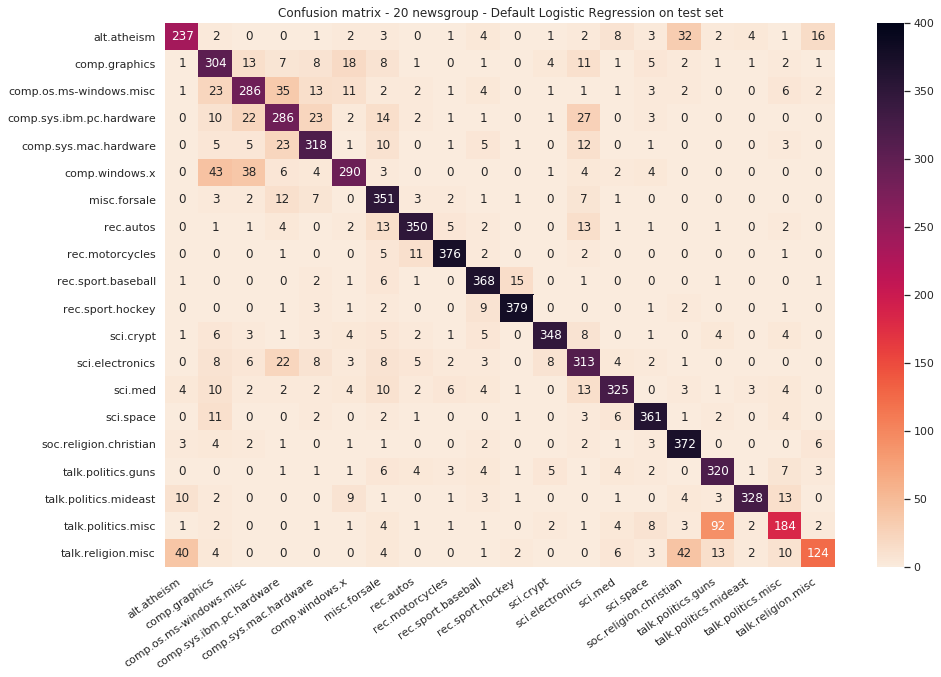

In [0]:
plt.figure(figsize = (15,10))
ax = sns.heatmap(df_def_cm, annot=True, fmt='d', cmap=sns.cm.rocket_r, vmin=0, vmax=400)
ax.set_title("Confusion matrix - 20 newsgroup - Default Logistic Regression on test set")
ax.set_xticklabels(ax.get_xticklabels(),rotation=35, horizontalalignment='right')
plt.show()

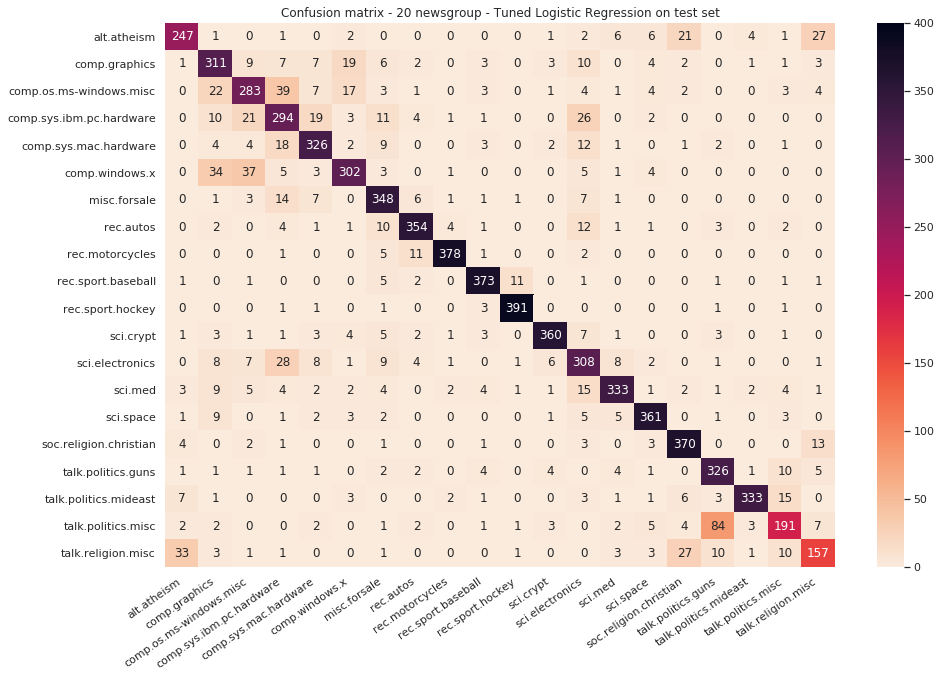

In [0]:
plt.figure(figsize = (15,10))
ax = sns.heatmap(df_tun_cm, annot=True, fmt='d', cmap=sns.cm.rocket_r, vmin=0, vmax=400)
ax.set_title("Confusion matrix - 20 newsgroup - Tuned Logistic Regression on test set")
ax.set_xticklabels(ax.get_xticklabels(),rotation=35, horizontalalignment='right')
plt.show()

#### IMDB reviews

Reset data to non engineered version


In [0]:
tfidf_vect = TfidfVectorizer()
imdb_X_train_tfidf = tfidf_vect.fit_transform(imdb_X_train)
imdb_X_test_tfidf = tfidf_vect.transform(imdb_X_test)

Default without feature engineering

In [0]:
lr_imdb_default_no_feat_eng = LogisticRegression(random_state=SEED)

In [0]:
lr_imdb_default_no_feat_eng.fit(imdb_X_train_tfidf, imdb_y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=551, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
lr_imdb_cv_score_1 = cross_val_score(lr_imdb_default_no_feat_eng, imdb_X_train_tfidf, imdb_y_train)

In [0]:
lr_imdb_cv_score_1.mean()

0.88828

Save the predictions, since we will change how we vectorize the test data for feature engineering - we'll compare the accuracy of these predictions against the feature engineered models in the results section down below


In [0]:
default_no_eng_y_pred = lr_imdb_default_no_feat_eng.predict(imdb_X_test_tfidf)

##### Default LogisticRegression

Feature selections/reduction

In [0]:
lr_clf = LogisticRegression(random_state=SEED, max_iter=1000)

No selection (baseline)

In [0]:
print("Number of features:", imdb_X_train_tfidf.shape[1])

Number of features: 74843


In [0]:
cv_score_min_df = cross_val_score(lr_clf, imdb_X_train_tfidf, imdb_y_train)
print("CV_score:", cv_score_min_df.mean())

CV_score: 0.88828


min_df=2

In [0]:
tfidf_vect = TfidfVectorizer(min_df=2)
imdb_X_train_tfidf = tfidf_vect.fit_transform(imdb_X_train)
print("Number of features:", imdb_X_train_tfidf.shape[1])

Number of features: 44796


In [0]:
cv_score_min_df_2 = cross_val_score(lr_clf, imdb_X_train_tfidf, imdb_y_train)

In [0]:
print("CV_score:", cv_score_min_df_2.mean())

CV_score: 0.8882


min_df=3

In [0]:
tfidf_vect = TfidfVectorizer(min_df=3)
imdb_X_train_tfidf = tfidf_vect.fit_transform(imdb_X_train)
print("Number of features:", imdb_X_train_tfidf.shape[1])

Number of features: 35852


In [0]:
cv_score_min_df_3 = cross_val_score(lr_clf, imdb_X_train_tfidf, imdb_y_train)

In [0]:
print("CV_score:", cv_score_min_df_3.mean())

CV_score: 0.88832


min_df=4

In [0]:
tfidf_vect = TfidfVectorizer(min_df=4)
imdb_X_train_tfidf = tfidf_vect.fit_transform(imdb_X_train)
print("Number of features:", imdb_X_train_tfidf.shape[1])

Number of features: 30768


In [0]:
cv_score_min_df_4 = cross_val_score(lr_clf, imdb_X_train_tfidf, imdb_y_train)

In [0]:
print("CV_score:", cv_score_min_df_4.mean())

CV_score: 0.8880800000000001


min_df=.0001

In [0]:
tfidf_vect = TfidfVectorizer(min_df=.001)
imdb_X_train_tfidf = tfidf_vect.fit_transform(imdb_X_train)
print("Number of features:", imdb_X_train_tfidf.shape[1])

Number of features: 10455


In [0]:
cv_score_min_df_0001 = cross_val_score(lr_clf, imdb_X_train_tfidf, imdb_y_train)

In [0]:
print("CV_score:", cv_score_min_df_0001.mean())

CV_score: 0.8869599999999999


We think setting min_df at 3 for IMDB reviews is a descent tradeoff between performance and feature reduction. The number of features gets reduced while the average CV score is the highest at 88.832

Actual default model (w/ feature engineering)


In [0]:
lr_imdb_default = LogisticRegression(random_state=SEED, max_iter=1000)

In [0]:
tfidf_vect = TfidfVectorizer(min_df=3)
imdb_X_train_tfidf = tfidf_vect.fit_transform(imdb_X_train)
imdb_X_test_tfidf = tfidf_vect.transform(imdb_X_test)

In [0]:
lr_imdb_default.fit(imdb_X_train_tfidf, imdb_y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=551, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
lr_imdb_cv_score_2 = cross_val_score(lr_imdb_default, imdb_X_train_tfidf, imdb_y_train)

In [0]:
lr_imdb_cv_score_2.mean()

0.88832

##### Hyperparameter tuning

Perform Grid Search to find best hyperparameters to train model

In [0]:
lr_gridsearch_parameters = {'C': uniform(loc=0, scale=10)}

In [0]:
lr_imdb_gs = RandomizedSearchCV(lr_clf, lr_gridsearch_parameters, n_iter=50, random_state=SEED, cv=3, n_jobs=-1, verbose=1)

In [0]:
start = time.time()

lr_imdb_gs = lr_imdb_gs.fit(imdb_X_train_tfidf, imdb_y_train)

print("RandomizedSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.time() - start, len(lr_imdb_gs.cv_results_['params'])))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.7min finished


RandomizedSearchCV took 227.67 seconds for 50 candidate parameter settings.


In [0]:
lr_imdb_gs.best_estimator_.get_params()

{'C': 5.821094045185146,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 551,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [0]:
report(lr_imdb_gs.cv_results_)

Model with rank: 1
Mean validation score: 0.89296 (std: 0.00272)
Parameters: {'C': 5.821094045185146}

Model with rank: 1
Mean validation score: 0.89296 (std: 0.00272)
Parameters: {'C': 5.804937991644083}

Model with rank: 3
Mean validation score: 0.89296 (std: 0.00273)
Parameters: {'C': 6.150185484308755}

Model with rank: 4
Mean validation score: 0.89296 (std: 0.00256)
Parameters: {'C': 6.264960777029969}

Model with rank: 4
Mean validation score: 0.89296 (std: 0.00256)
Parameters: {'C': 5.909147848609875}



Tuned model

In [0]:
lr_imdb_tuned = LogisticRegression(**{'C': 5.821094045185146,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 551,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False})

In [0]:
lr_imdb_tuned.fit(imdb_X_train_tfidf, imdb_y_train)

LogisticRegression(C=5.821094045185146, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=551, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
lr_imdb_cv_score_3 = cross_val_score(lr_imdb_tuned, imdb_X_train_tfidf, imdb_y_train)

In [0]:
lr_imdb_cv_score_3.mean()

0.8949999999999999

##### Results

Now we compare the default model and the tuned model on the test set

In [0]:
default_y_pred = lr_imdb_default.predict(imdb_X_test_tfidf)

In [0]:
tuned_y_pred = lr_imdb_tuned.predict(imdb_X_test_tfidf)

In [0]:
default_no_eng_acc = metrics.accuracy_score(imdb_y_test, default_no_eng_y_pred)

In [0]:
default_acc = metrics.accuracy_score(imdb_y_test, default_y_pred)

In [0]:
tuned_acc = metrics.accuracy_score(imdb_y_test, tuned_y_pred)

In [0]:
print("Validation Accuracy")
print("Default model w/o feat. eng.:\t", lr_imdb_cv_score_1.mean())
print("Default model w/ feat. eng.:\t", lr_imdb_cv_score_2.mean())
print("Tuned model w/ feat. eng.:\t", lr_imdb_cv_score_3.mean())

Validation Accuracy
Default model w/o feat. eng.:	 0.88828
Default model w/ feat. eng.:	 0.88832
Tuned model w/ feat. eng.:	 0.8949999999999999


In [0]:
print("Test Accuracy")
print("Default model w/o feat. eng.:\t", default_no_eng_acc)
print("Default model w/ feat. eng.:\t", default_acc)
print("Tuned model w/ feat. eng.:\t", tuned_acc)

Test Accuracy
Default model w/o feat. eng.:	 0.88272
Default model w/ feat. eng.:	 0.88288
Tuned model w/ feat. eng.:	 0.88348


Save test accuracies for plot later

In [0]:
lr_imdb_test_acc_1 = default_no_eng_acc
lr_imdb_test_acc_2 = default_acc
lr_imdb_test_acc_3 = tuned_acc

In [0]:
default_cm = metrics.confusion_matrix(imdb_y_test, default_y_pred)
tuned_cm = metrics.confusion_matrix(imdb_y_test, tuned_y_pred)

In [0]:
df_def_cm = pd.DataFrame(default_cm, ['Negative', 'Positive'], ['Negative', 'Positive'])
df_tun_cm = pd.DataFrame(tuned_cm, ['Negative', 'Positive'], ['Negative', 'Positive'])

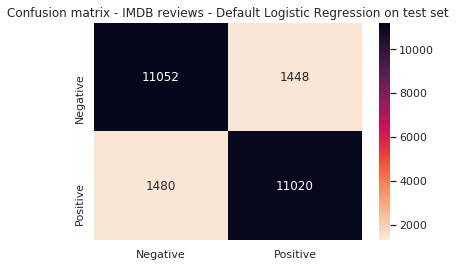

In [0]:
ax = sns.heatmap(df_def_cm, annot=True, fmt='d', cmap=sns.cm.rocket_r, vmin=1300, vmax=11200)
ax.set_title("Confusion matrix - IMDB reviews - Default Logistic Regression on test set")
plt.show()

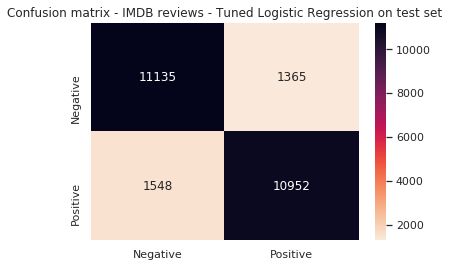

In [0]:
ax = sns.heatmap(df_tun_cm, annot=True, fmt='d', cmap=sns.cm.rocket_r, vmin=1300, vmax=11200)
ax.set_title("Confusion matrix - IMDB reviews - Tuned Logistic Regression on test set")
plt.show()

### Decision trees

In [0]:
from sklearn.tree import DecisionTreeClassifier

#### 20 news

Reset data to non engineered version


In [0]:
tfidf_vect = TfidfVectorizer()
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
news_X_test = tfidf_vect.transform(newsgroups_test.data)

Default without feature engineering

In [0]:
dt_news_default_no_feat_eng = DecisionTreeClassifier(random_state=SEED)

In [0]:
dt_news_default_no_feat_eng.fit(news_X_train, newsgroups_train.target)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=551, splitter='best')

In [0]:
dt_news_cv_score_1 = cross_val_score(dt_news_default_no_feat_eng, news_X_train, newsgroups_train.target)

In [0]:
dt_news_cv_score_1.mean()

0.6324040332055326

Save the predictions, since we will change how we vectorize the test data for feature engineering - we'll compare the accuracy of these predictions against the feature engineered models in the results section down below


In [0]:
default_no_eng_y_pred = dt_news_default_no_feat_eng.predict(news_X_test)

##### Default DecisionTreeClassifier

Feature selections/reduction

20 newsgroup has an extremely large number of features if we just vectorize it without any constraints: 130107. We aim to reduce the number of features while retaining a descent performance of the model in order to improve training times (training on the entire feature set may yield better results but would explode the training time required to perform hyperparameter tuning)

In [0]:
dt_clf = DecisionTreeClassifier(random_state=SEED)

No selection (baseline) default CountVectorizer + TfidfTransformer

In [0]:
print("Number of features:", news_X_train_tfidf.shape[1])

Number of features: 130107


In [0]:
cv_score_min_df = cross_val_score(dt_clf, news_X_train_tfidf, newsgroups_train.target)
print("CV_score:", cv_score_min_df.mean())

CV_score: 0.6324040332055326


min_df=2

In [0]:
tfidf_vect = TfidfVectorizer(min_df=2)
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
print("Number of features:", news_X_train.shape[1])

Number of features: 56436


In [0]:
cv_score_min_df_2 = cross_val_score(dt_clf, news_X_train, newsgroups_train.target)

In [0]:
print("CV_score:", cv_score_min_df_2.mean())

CV_score: 0.6243602441615455


min_df=3

In [0]:
tfidf_vect = TfidfVectorizer(min_df=3)
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
print("Number of features:", news_X_train.shape[1])

Number of features: 38869


In [0]:
cv_score_min_df_3 = cross_val_score(dt_clf, news_X_train, newsgroups_train.target)

In [0]:
print("CV_score:", cv_score_min_df_3.mean())

CV_score: 0.6250671530205868


min_df=4

In [0]:
tfidf_vect = TfidfVectorizer(min_df=4)
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
print("Number of features:", news_X_train.shape[1])

Number of features: 30819


In [0]:
cv_score_min_df_4 = cross_val_score(dt_clf, news_X_train, newsgroups_train.target)

In [0]:
print("CV_score:", cv_score_min_df_4.mean())

CV_score: 0.6244481535703137


min_df=.0001

In [0]:
tfidf_vect = TfidfVectorizer(min_df=.001)
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
print("Number of features:", news_X_train.shape[1])

Number of features: 13509


In [0]:
cv_score_min_df_0001 = cross_val_score(dt_clf, news_X_train, newsgroups_train.target)

In [0]:
print("CV_score:", cv_score_min_df_0001.mean())

CV_score: 0.6225913505737359


min_df=.0005

In [0]:
tfidf_vect = TfidfVectorizer(min_df=.0005)
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
print("Number of features:", news_X_train.shape[1])

Number of features: 22707


In [0]:
cv_score_min_df_0005 = cross_val_score(dt_clf, news_X_train, newsgroups_train.target)

In [0]:
print("CV_score:", cv_score_min_df_0005.mean())

CV_score: 0.6251552577835967


min_df=.0001


In [0]:
fidf_vect = TfidfVectorizer(min_df=.0001)
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
print("Number of features:", news_X_train.shape[1])

Number of features: 22707


In [0]:
cv_score_min_df_0001 = cross_val_score(dt_clf, news_X_train, newsgroups_train.target)

In [0]:
print("CV_score:", cv_score_min_df_0001.mean())

CV_score: 0.6251552577835967


We think setting min_df at .0005 for 20newsgroup is a descent tradeoff between performance and feature reduction. The number of features gets slashed from 130107 to 22707 while the average CV score is only decreased by ~0.007

Actual default model

In [0]:
dt_news_default = DecisionTreeClassifier(random_state=SEED)

In [0]:
tfidf_vect = TfidfVectorizer(min_df=.0005)
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
news_X_test = tfidf_vect.transform(newsgroups_test.data)

In [0]:
dt_news_default.fit(news_X_train, newsgroups_train.target)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=551, splitter='best')

In [0]:
dt_news_cv_score_2 = cross_val_score(dt_news_default, news_X_train, newsgroups_train.target)

In [0]:
dt_news_cv_score_2.mean()

0.6251552577835967

##### Hyperparameter tuning

Perform Grid Search to find best hyperparameters to train model

In [0]:
dt_gridsearch_parameters = {
    "min_samples_split": randint(2, 40),
    "min_samples_leaf": randint(1, 20),
    'max_features': randint(2, 10000)
}

In [0]:
dt_news_rs = RandomizedSearchCV(dt_clf, dt_gridsearch_parameters, n_iter=100, random_state=SEED, cv=5, n_jobs=-1, verbose=1)

In [0]:
start = time.time()

dt_news_rs.fit(news_X_train, newsgroups_train.target)

print("RandomizedSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.time() - start, len(dt_news_rs.cv_results_['params'])))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11.9min finished


RandomizedSearchCV took 720.28 seconds for 100 candidate parameter settings.


In [0]:
dt_news_rs.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 7579,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 27,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 551,
 'splitter': 'best'}

In [0]:
report(dt_news_rs.cv_results_)

Model with rank: 1
Mean validation score: 0.63302 (std: 0.00933)
Parameters: {'max_features': 7579, 'min_samples_leaf': 1, 'min_samples_split': 27}

Model with rank: 2
Mean validation score: 0.62630 (std: 0.01033)
Parameters: {'max_features': 7970, 'min_samples_leaf': 5, 'min_samples_split': 35}

Model with rank: 3
Mean validation score: 0.62295 (std: 0.01289)
Parameters: {'max_features': 5629, 'min_samples_leaf': 4, 'min_samples_split': 19}

Model with rank: 4
Mean validation score: 0.62153 (std: 0.00561)
Parameters: {'max_features': 9405, 'min_samples_leaf': 2, 'min_samples_split': 28}

Model with rank: 5
Mean validation score: 0.62144 (std: 0.00671)
Parameters: {'max_features': 4363, 'min_samples_leaf': 2, 'min_samples_split': 20}



Tuned model

In [0]:
dt_news_tuned = DecisionTreeClassifier(**{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 7579,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 27,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 551,
 'splitter': 'best'})

In [0]:
dt_news_tuned.fit(news_X_train, newsgroups_train.target)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=7579, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=27,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=551, splitter='best')

In [0]:
dt_news_cv_score_3 = cross_val_score(dt_news_tuned, news_X_train, newsgroups_train.target)

In [0]:
dt_news_cv_score_3.mean()

0.6330220949554455

##### Results

Now we compare the default model and the tuned model on the test set

In [0]:
default_y_pred = dt_news_default.predict(news_X_test)

In [0]:
tuned_y_pred = dt_news_tuned.predict(news_X_test)

In [0]:
default_no_eng_acc = metrics.accuracy_score(newsgroups_test.target, default_no_eng_y_pred)

In [0]:
default_acc = metrics.accuracy_score(newsgroups_test.target, default_y_pred)

In [0]:
tuned_acc = metrics.accuracy_score(newsgroups_test.target, tuned_y_pred)

In [0]:
print("Validation Accuracy")
print("Default model w/o feat. eng.:\t", dt_news_cv_score_1.mean())
print("Default model w/ feat. eng.:\t", dt_news_cv_score_2.mean())
print("Tuned model w/ feat. eng.:\t", dt_news_cv_score_3.mean())

Validation Accuracy
Default model w/o feat. eng.:	 0.6324040332055326
Default model w/ feat. eng.:	 0.6251552577835967
Tuned model w/ feat. eng.:	 0.6330220949554455


In [0]:
print("Test Accuracy")
print("Default model w/o feat. eng.:\t", default_no_eng_acc)
print("Default model w/ feat. eng.:\t", default_acc)
print("Tuned model w/ feat. eng.:\t", tuned_acc)

Test Accuracy
Default model w/o feat. eng.:	 0.5521773765268189
Default model w/ feat. eng.:	 0.5596123207647371
Tuned model w/ feat. eng.:	 0.5601433882103027


In [0]:
default_cm = metrics.confusion_matrix(newsgroups_test.target, default_y_pred)
tuned_cm = metrics.confusion_matrix(newsgroups_test.target, tuned_y_pred)

In [0]:
df_def_cm = pd.DataFrame(default_cm, newsgroups_train.target_names, newsgroups_train.target_names)
df_tun_cm = pd.DataFrame(tuned_cm, newsgroups_train.target_names, newsgroups_train.target_names)

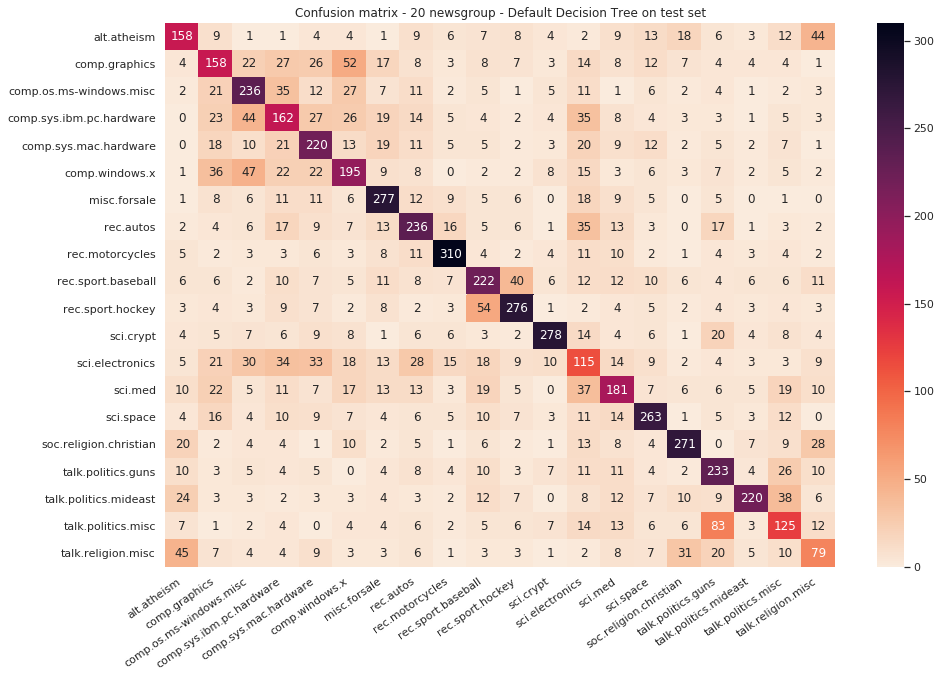

In [0]:
plt.figure(figsize = (15,10))
ax = sns.heatmap(df_def_cm, annot=True, fmt='d', cmap=sns.cm.rocket_r, vmin=0, vmax=310)
ax.set_title("Confusion matrix - 20 newsgroup - Default Decision Tree on test set")
ax.set_xticklabels(ax.get_xticklabels(),rotation=35, horizontalalignment='right')
plt.show()

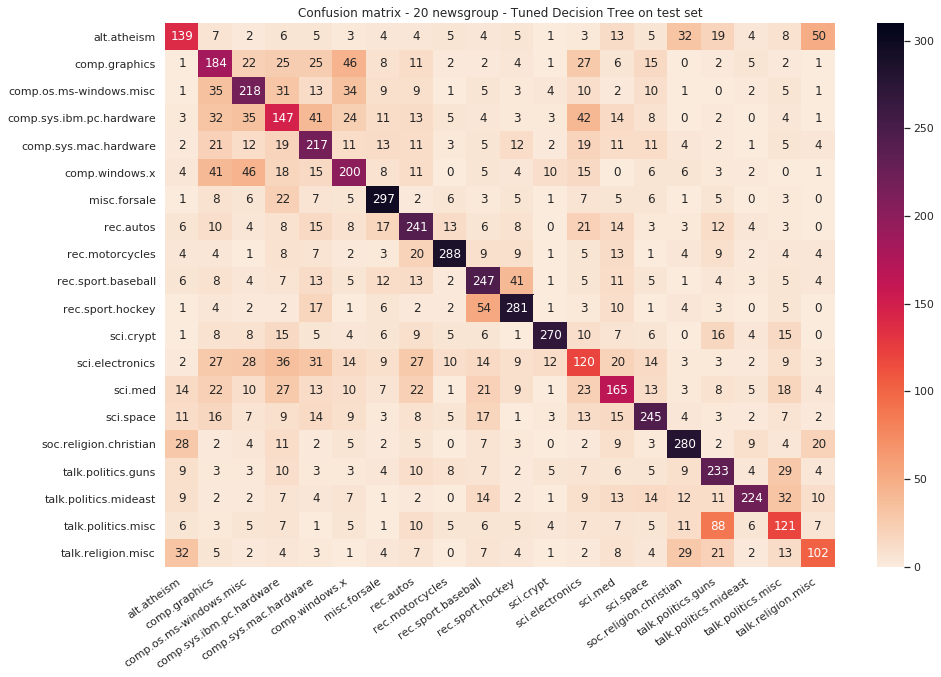

In [0]:
plt.figure(figsize = (15,10))
ax = sns.heatmap(df_tun_cm, annot=True, fmt='d', cmap=sns.cm.rocket_r, vmin=0, vmax=310)
ax.set_title("Confusion matrix - 20 newsgroup - Tuned Decision Tree on test set")
ax.set_xticklabels(ax.get_xticklabels(),rotation=35, horizontalalignment='right')
plt.show()

#### IMDB reviews

Reset data to non engineered version


In [0]:
tfidf_vect = TfidfVectorizer()
imdb_X_train_tfidf = tfidf_vect.fit_transform(imdb_X_train)
imdb_X_test_tfidf = tfidf_vect.transform(imdb_X_test)

Default without feature engineering

In [0]:
dt_imdb_default_no_feat_eng = DecisionTreeClassifier(random_state=SEED)

In [0]:
dt_imdb_default_no_feat_eng.fit(imdb_X_train_tfidf, imdb_y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=551, splitter='best')

In [0]:
dt_imdb_cv_score_1 = cross_val_score(dt_imdb_default_no_feat_eng, imdb_X_train_tfidf, imdb_y_train)

In [0]:
dt_imdb_cv_score_1.mean()

0.70312

Save the predictions, since we will change how we vectorize the train/test data for feature engineering - we'll compare the accuracy of these predictions against the feature engineered models in the Results section down below

In [0]:
default_no_eng_y_pred = dt_imdb_default_no_feat_eng.predict(imdb_X_test_tfidf)

##### Default DecisionTreeClassifier

Feature selections/reduction

In [0]:
dt_clf = DecisionTreeClassifier(random_state=SEED)

No selection (baseline)

In [0]:
print("Number of features:", imdb_X_train_tfidf.shape[1])

Number of features: 74843


In [0]:
cv_score_min_df = cross_val_score(dt_clf, imdb_X_train_tfidf, imdb_y_train)
print("CV_score:", cv_score_min_df.mean())

CV_score: 0.70312


min_df=2

In [0]:
tfidf_vect = TfidfVectorizer(min_df=2)
imdb_X_train_tfidf = tfidf_vect.fit_transform(imdb_X_train)
print("Number of features:", imdb_X_train_tfidf.shape[1])

Number of features: 44796


In [0]:
cv_score_min_df_2 = cross_val_score(dt_clf, imdb_X_train_tfidf, imdb_y_train)

In [0]:
print("CV_score:", cv_score_min_df_2.mean())

CV_score: 0.6991600000000001


min_df=3

In [0]:
tfidf_vect = TfidfVectorizer(min_df=3)
imdb_X_train_tfidf = tfidf_vect.fit_transform(imdb_X_train)
print("Number of features:", imdb_X_train_tfidf.shape[1])

Number of features: 35852


In [0]:
cv_score_min_df_3 = cross_val_score(dt_clf, imdb_X_train_tfidf, imdb_y_train)

In [0]:
print("CV_score:", cv_score_min_df_3.mean())

CV_score: 0.7012


min_df=4

In [0]:
tfidf_vect = TfidfVectorizer(min_df=4)
imdb_X_train_tfidf = tfidf_vect.fit_transform(imdb_X_train)
print("Number of features:", imdb_X_train_tfidf.shape[1])

Number of features: 30768


In [0]:
cv_score_min_df_4 = cross_val_score(dt_clf, imdb_X_train_tfidf, imdb_y_train)

In [0]:
print("CV_score:", cv_score_min_df_4.mean())

CV_score: 0.69892


min_df=.0001

In [0]:
tfidf_vect = TfidfVectorizer(min_df=.001)
imdb_X_train_tfidf = tfidf_vect.fit_transform(imdb_X_train)
print("Number of features:", imdb_X_train_tfidf.shape[1])

Number of features: 10455


In [0]:
cv_score_min_df_0001 = cross_val_score(dt_clf, imdb_X_train_tfidf, imdb_y_train)

In [0]:
print("CV_score:", cv_score_min_df_0001.mean())

CV_score: 0.7011200000000001


We think setting min_df at 3 (again) for IMDB reviews is a descent tradeoff between performance and feature reduction. The number of features gets reduced while the average CV score doesn't get reduced by much ~0.002

Actual decision tree classifier

In [0]:
dt_imdb_default = DecisionTreeClassifier(random_state=SEED)

In [0]:
tfidf_vect = TfidfVectorizer(min_df=3)
imdb_X_train_tfidf = tfidf_vect.fit_transform(imdb_X_train)
imdb_X_test_tfidf = tfidf_vect.transform(imdb_X_test)

In [0]:
dt_imdb_default.fit(imdb_X_train_tfidf, imdb_y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=551, splitter='best')

In [0]:
dt_imdb_cv_score_2 = cross_val_score(dt_imdb_default, imdb_X_train_tfidf, imdb_y_train)

In [0]:
dt_imdb_cv_score_2.mean()

0.7012

##### Hyperparameter tuning

Perform Grid Search to find best hyperparameters to train model

In [0]:
dt_gridsearch_parameters = {
    "min_samples_split": randint(2, 10),
    "max_depth": randint(1, 70),
    "min_samples_leaf": randint(1, 20),
    "max_leaf_nodes": randint(2, 50)
}

In [0]:
dt_imdb_rs = RandomizedSearchCV(dt_clf, dt_gridsearch_parameters, n_iter=150, random_state=SEED, cv=3, n_jobs=-1, verbose=1)

In [0]:
start = time.time()

dt_imdb_rs.fit(imdb_X_train_tfidf, imdb_y_train)

print("RandomizedSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.time() - start, len(dt_imdb_rs.cv_results_['params'])))

Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 17.7min finished


RandomizedSearchCV took 1070.94 seconds for 150 candidate parameter settings.


In [0]:
dt_imdb_rs.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 57,
 'max_features': None,
 'max_leaf_nodes': 47,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 17,
 'min_samples_split': 6,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 551,
 'splitter': 'best'}

In [0]:
report(dt_imdb_rs.cv_results_)

Model with rank: 1
Mean validation score: 0.72864 (std: 0.00549)
Parameters: {'max_depth': 57, 'max_leaf_nodes': 47, 'min_samples_leaf': 17, 'min_samples_split': 6}

Model with rank: 1
Mean validation score: 0.72864 (std: 0.00549)
Parameters: {'max_depth': 27, 'max_leaf_nodes': 47, 'min_samples_leaf': 4, 'min_samples_split': 3}

Model with rank: 1
Mean validation score: 0.72864 (std: 0.00549)
Parameters: {'max_depth': 52, 'max_leaf_nodes': 47, 'min_samples_leaf': 10, 'min_samples_split': 6}

Model with rank: 1
Mean validation score: 0.72864 (std: 0.00549)
Parameters: {'max_depth': 49, 'max_leaf_nodes': 47, 'min_samples_leaf': 2, 'min_samples_split': 2}

Model with rank: 5
Mean validation score: 0.72844 (std: 0.00528)
Parameters: {'max_depth': 66, 'max_leaf_nodes': 49, 'min_samples_leaf': 10, 'min_samples_split': 4}

Model with rank: 5
Mean validation score: 0.72844 (std: 0.00528)
Parameters: {'max_depth': 52, 'max_leaf_nodes': 48, 'min_samples_leaf': 13, 'min_samples_split': 2}

Model 

Tuned model

In [0]:
dt_imdb_tuned = DecisionTreeClassifier(**{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 57,
 'max_features': None,
 'max_leaf_nodes': 47,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 17,
 'min_samples_split': 6,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 551,
 'splitter': 'best'})

In [0]:
dt_imdb_tuned.fit(imdb_X_train_tfidf, imdb_y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=57, max_features=None, max_leaf_nodes=47,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=17, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=551, splitter='best')

In [0]:
dt_imdb_cv_score_3 = cross_val_score(dt_imdb_tuned, imdb_X_train_tfidf, imdb_y_train)

In [0]:
dt_imdb_cv_score_3.mean()

0.73192

##### Results

Now we compare the default model and the tuned model on the test set

In [0]:
default_y_pred = dt_imdb_default.predict(imdb_X_test_tfidf)

In [0]:
tuned_y_pred = dt_imdb_tuned.predict(imdb_X_test_tfidf)

In [0]:
default_no_eng_acc = metrics.accuracy_score(imdb_y_test, default_no_eng_y_pred)

In [0]:
default_acc = metrics.accuracy_score(imdb_y_test, default_y_pred)

In [0]:
tuned_acc = metrics.accuracy_score(imdb_y_test, tuned_y_pred)

In [0]:
print("Validation Accuracy")
print("Default model w/o feat. eng.:\t", dt_imdb_cv_score_1.mean())
print("Default model w/ feat. eng.:\t", dt_imdb_cv_score_2.mean())
print("Tuned model w/ feat. eng.:\t", dt_imdb_cv_score_3.mean())

Validation Accuracy
Default model w/o feat. eng.:	 0.70312
Default model w/ feat. eng.:	 0.7012
Tuned model w/ feat. eng.:	 0.73192


In [0]:
print("Test Accuracy")
print("Default model w/o feat. eng.:\t", default_no_eng_acc)
print("Default model w/ feat. eng.:\t", default_acc)
print("Tuned model w/ feat. eng.:\t", tuned_acc)

Test Accuracy
Default model w/o feat. eng.:	 0.69888
Default model w/ feat. eng.:	 0.70504
Tuned model w/ feat. eng.:	 0.73604


In [0]:
default_cm = metrics.confusion_matrix(imdb_y_test, default_y_pred)
tuned_cm = metrics.confusion_matrix(imdb_y_test, tuned_y_pred)

In [0]:
df_def_cm = pd.DataFrame(default_cm, ['Negative', 'Positive'], ['Negative', 'Positive'])
df_tun_cm = pd.DataFrame(tuned_cm, ['Negative', 'Positive'], ['Negative', 'Positive'])

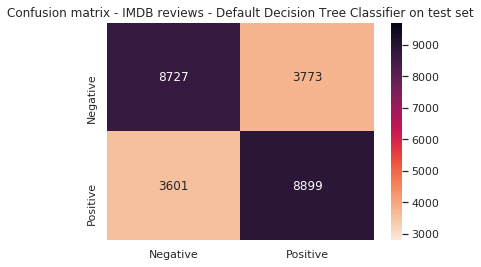

In [0]:
ax = sns.heatmap(df_def_cm, annot=True, fmt='d', cmap=sns.cm.rocket_r, vmin=2800, vmax=9700)
ax.set_title("Confusion matrix - IMDB reviews - Default Decision Tree Classifier on test set")
plt.show()

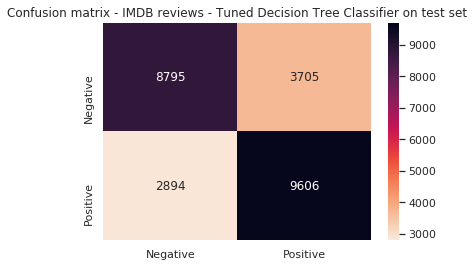

In [0]:
ax = sns.heatmap(df_tun_cm, annot=True, fmt='d', cmap=sns.cm.rocket_r, vmin=2800, vmax=9700)
ax.set_title("Confusion matrix - IMDB reviews - Tuned Decision Tree Classifier on test set")
plt.show()

###Support Vector Machines

In [0]:
from sklearn.svm import LinearSVC

#### 20 news

Reset data to non engineered version


In [0]:
tfidf_vect = TfidfVectorizer()
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
news_X_test = tfidf_vect.transform(newsgroups_test.data)

Default without feature engineering

In [0]:
svm_news_default_no_feat_eng = LinearSVC(random_state=SEED)

In [0]:
svm_news_default_no_feat_eng.fit(news_X_train, newsgroups_train.target)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=551, tol=0.0001,
          verbose=0)

In [0]:
svm_news_cv_score_1 = cross_val_score(svm_news_default_no_feat_eng, news_X_train, newsgroups_train.target)

In [0]:
svm_news_cv_score_1.mean()

0.9251377931143882

Save the predictions, since we will change how we vectorize the test data for feature engineering - we'll compare the accuracy of these predictions against the feature engineered models in the results section down below


In [0]:
default_no_eng_y_pred = svm_news_default_no_feat_eng.predict(news_X_test)

##### Default DecisionTreeClassifier

Feature selections/reduction

20 newsgroup has an extremely large number of features if we just vectorize it without any constrains: 130107. We aim to reduce the number of features while retaining a descent performance of the model in order to improve training times (training on the entire feature set may yield better results but would explode the training time required to perform hyperparameter tuning)

In [0]:
svm_clf = LinearSVC(random_state=SEED)

No selection (baseline) default CountVectorizer + TfidfTransformer

In [0]:
print("Number of features:", news_X_train_tfidf.shape[1])

Number of features: 130107


In [0]:
cv_score_min_df = cross_val_score(svm_clf, news_X_train_tfidf, newsgroups_train.target)
print("CV_score:", cv_score_min_df.mean())

CV_score: 0.9251377931143882


min_df=2

In [0]:
tfidf_vect = TfidfVectorizer(min_df=2)
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
print("Number of features:", news_X_train.shape[1])

Number of features: 56436


In [0]:
cv_score_min_df_2 = cross_val_score(svm_clf, news_X_train, newsgroups_train.target)

In [0]:
print("CV_score:", cv_score_min_df_2.mean())

CV_score: 0.9238120020176186


min_df=3

In [0]:
tfidf_vect = TfidfVectorizer(min_df=3)
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
print("Number of features:", news_X_train.shape[1])

Number of features: 38869


In [0]:
cv_score_min_df_3 = cross_val_score(svm_clf, news_X_train, newsgroups_train.target)

In [0]:
print("CV_score:", cv_score_min_df_3.mean())

CV_score: 0.922486093708304


min_df=4

In [0]:
tfidf_vect = TfidfVectorizer(min_df=4)
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
print("Number of features:", news_X_train.shape[1])

Number of features: 30819


In [0]:
cv_score_min_df_4 = cross_val_score(svm_clf, news_X_train, newsgroups_train.target)

In [0]:
print("CV_score:", cv_score_min_df_4.mean())

CV_score: 0.9200996853624582


min_df=.001

In [0]:
tfidf_vect = TfidfVectorizer(min_df=.001)
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
print("Number of features:", news_X_train.shape[1])

Number of features: 13509


In [0]:
cv_score_min_df_001 = cross_val_score(svm_clf, news_X_train, newsgroups_train.target)

In [0]:
print("CV_score:", cv_score_min_df_001.mean())

CV_score: 0.9110844778161583


We think performing no feature selection for 20newsgroup  for SVM is acceptable, since SVM seems to perform best when no features are removed. Additionally, the training time is extremely fast despite the large number of instances and features.

Actual default model

In [0]:
svm_news_default = LinearSVC(random_state=SEED)

In [0]:
tfidf_vect = TfidfVectorizer()
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
news_X_test = tfidf_vect.transform(newsgroups_test.data)

In [0]:
svm_news_default.fit(news_X_train, newsgroups_train.target)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=551, tol=0.0001,
          verbose=0)

In [0]:
svm_news_cv_score_2 = cross_val_score(svm_news_default, news_X_train, newsgroups_train.target)

In [0]:
svm_news_cv_score_2.mean()

0.9251377931143882

##### Hyperparameter tuning

Perform Grid Search to find best hyperparameters to train model

In [0]:
svm_gridsearch_parameters = {
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'C': uniform(loc=0, scale=4),
    'max_iter': randint(800, 3000)
}

In [0]:
svm_news_rs = RandomizedSearchCV(svm_clf, svm_gridsearch_parameters, n_iter=100, random_state=SEED, cv=3, n_jobs=-1, verbose=1)

In [0]:
start = time.time()

svm_news_rs.fit(news_X_train, newsgroups_train.target)

print("RandomizedSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.time() - start, len(svm_news_rs.cv_results_['params'])))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 11.2min finished


RandomizedSearchCV took 673.44 seconds for 100 candidate parameter settings.


In [0]:
svm_news_rs.best_estimator_.get_params()

{'C': 1.252183016072279,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 2331,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 551,
 'tol': 0.0001,
 'verbose': 0}

In [0]:
report(svm_news_rs.cv_results_)

Model with rank: 1
Mean validation score: 0.91895 (std: 0.00360)
Parameters: {'C': 1.252183016072279, 'loss': 'squared_hinge', 'max_iter': 2331, 'penalty': 'l2'}

Model with rank: 2
Mean validation score: 0.91895 (std: 0.00315)
Parameters: {'C': 2.230986458050633, 'loss': 'squared_hinge', 'max_iter': 2624, 'penalty': 'l2'}

Model with rank: 3
Mean validation score: 0.91886 (std: 0.00375)
Parameters: {'C': 1.489764280621456, 'loss': 'squared_hinge', 'max_iter': 2079, 'penalty': 'l2'}

Model with rank: 4
Mean validation score: 0.91886 (std: 0.00303)
Parameters: {'C': 2.264966093330349, 'loss': 'squared_hinge', 'max_iter': 2291, 'penalty': 'l2'}

Model with rank: 5
Mean validation score: 0.91877 (std: 0.00400)
Parameters: {'C': 1.7723998204837486, 'loss': 'squared_hinge', 'max_iter': 1965, 'penalty': 'l2'}



Tuned model

In [0]:
svm_news_tuned = LinearSVC(**{'C': 1.252183016072279,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 2331,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 551,
 'tol': 0.0001,
 'verbose': 0})

In [0]:
svm_news_tuned.fit(news_X_train, newsgroups_train.target)

LinearSVC(C=1.252183016072279, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=2331,
          multi_class='ovr', penalty='l2', random_state=551, tol=0.0001,
          verbose=0)

In [0]:
svm_news_cv_score_3 = cross_val_score(svm_news_tuned, news_X_train, newsgroups_train.target)

In [0]:
svm_news_cv_score_3.mean()

0.9255796844091296

##### Results

Now we compare the default model and the tuned model on the test set

In [0]:
default_y_pred = svm_news_default.predict(news_X_test)

In [0]:
tuned_y_pred = svm_news_tuned.predict(news_X_test)

In [0]:
default_no_eng_acc = metrics.accuracy_score(newsgroups_test.target, default_no_eng_y_pred)

In [0]:
default_acc = metrics.accuracy_score(newsgroups_test.target, default_y_pred)

In [0]:
tuned_acc = metrics.accuracy_score(newsgroups_test.target, tuned_y_pred)

In [0]:
print("Validation Accuracy")
print("Default model w/o feat. eng.:\t", svm_news_cv_score_1.mean())
print("-Default model w/ feat. eng.:\t")
print("Tuned model w/o feat. eng.:\t", svm_news_cv_score_3.mean())

Validation Accuracy
Default model w/o feat. eng.:	 0.9251377931143882
-Default model w/ feat. eng.:	
Tuned model w/ feat. eng.:	 0.9255796844091296


In [0]:
print("Test Accuracy")
print("Default model w/o feat. eng.:\t", default_no_eng_acc)
print("-Default model w/ feat. eng.:\t")
print("Tuned model w/o feat. eng.:\t", tuned_acc)

Test Accuracy
Default model w/o feat. eng.:	 0.8531598513011153
-Default model w/ feat. eng.:	
Tuned model w/ feat. eng.:	 0.852761550716941


Save test accuracies for plot later

In [0]:
svm_news_test_acc_1 = default_no_eng_acc
svm_news_test_acc_2 = default_acc
svm_news_test_acc_3 = tuned_acc

Save predictions (BEST MODEL)

In [0]:
twenty_news_pred = default_no_eng_y_pred

In [0]:
default_cm = metrics.confusion_matrix(newsgroups_test.target, default_y_pred)
tuned_cm = metrics.confusion_matrix(newsgroups_test.target, tuned_y_pred)

In [0]:
df_def_cm = pd.DataFrame(default_cm, newsgroups_train.target_names, newsgroups_train.target_names)
df_tun_cm = pd.DataFrame(tuned_cm, newsgroups_train.target_names, newsgroups_train.target_names)

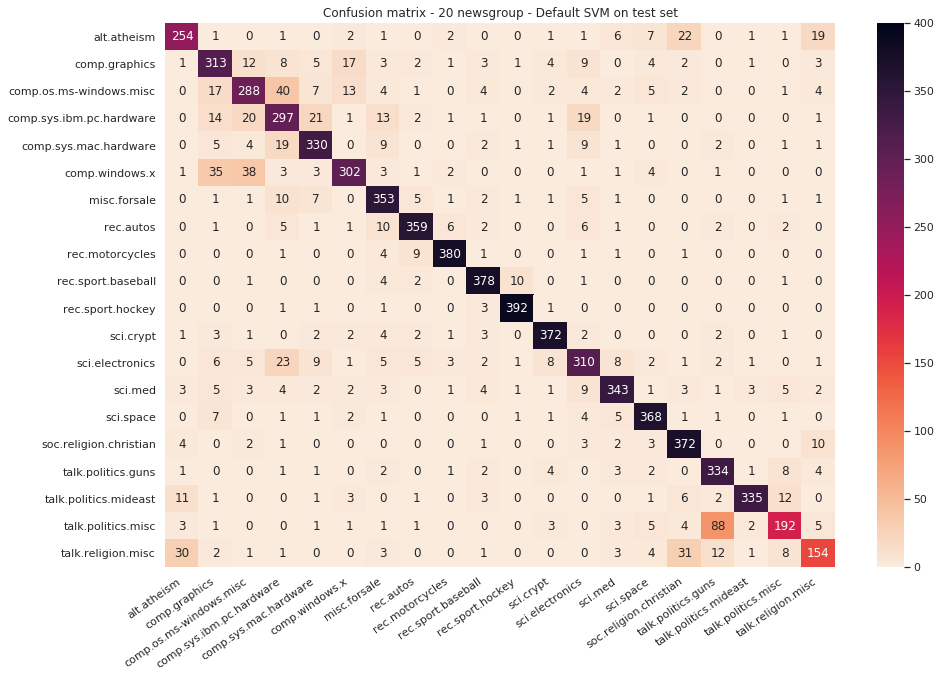

In [0]:
plt.figure(figsize = (15,10))
ax = sns.heatmap(df_def_cm, annot=True, fmt='d', cmap=sns.cm.rocket_r, vmin=0, vmax=400)
ax.set_title("Confusion matrix - 20 newsgroup - Default SVM on test set")
ax.set_xticklabels(ax.get_xticklabels(),rotation=35, horizontalalignment='right')
plt.show()

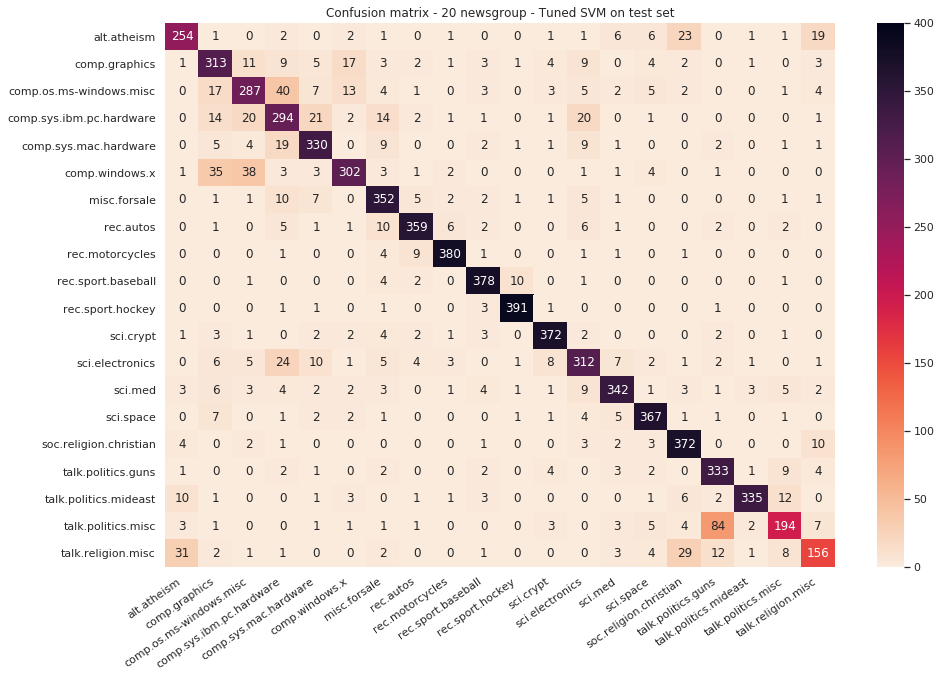

In [0]:
plt.figure(figsize = (15,10))
ax = sns.heatmap(df_tun_cm, annot=True, fmt='d', cmap=sns.cm.rocket_r, vmin=0, vmax=400)
ax.set_title("Confusion matrix - 20 newsgroup - Tuned SVM on test set")
ax.set_xticklabels(ax.get_xticklabels(),rotation=35, horizontalalignment='right')
plt.show()

#### IMDB reviews

Reset data to non engineered version


In [0]:
tfidf_vect = TfidfVectorizer()
imdb_X_train_tfidf = tfidf_vect.fit_transform(imdb_X_train)
imdb_X_test_tfidf = tfidf_vect.transform(imdb_X_test)

Default without feature engineering

In [0]:
svm_imdb_default_no_feat_eng = LinearSVC(random_state=SEED)

In [0]:
svm_imdb_default_no_feat_eng.fit(imdb_X_train_tfidf, imdb_y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=551, tol=0.0001,
          verbose=0)

In [0]:
svm_imdb_cv_score_1 = cross_val_score(svm_imdb_default_no_feat_eng, imdb_X_train_tfidf, imdb_y_train)

In [0]:
svm_imdb_cv_score_1.mean()

0.8947200000000001

Save the predictions, since we will change how we vectorize the test data for feature engineering - we'll compare the accuracy of these predictions against the feature engineered models in the results section down below


In [0]:
default_no_eng_y_pred = svm_imdb_default_no_feat_eng.predict(imdb_X_test_tfidf)

##### Default DecisionTreeClassifier

Feature selections/reduction

In [0]:
svm_clf = LinearSVC(random_state=SEED)

No selection (baseline)

In [0]:
print("Number of features:", imdb_X_train_tfidf.shape[1])

Number of features: 74843


In [0]:
cv_score_min_df = cross_val_score(svm_clf, imdb_X_train_tfidf, imdb_y_train)
print("CV_score:", cv_score_min_df.mean())

CV_score: 0.8947200000000001


min_df=2

In [0]:
tfidf_vect = TfidfVectorizer(min_df=2)
imdb_X_train_tfidf = tfidf_vect.fit_transform(imdb_X_train)
print("Number of features:", imdb_X_train_tfidf.shape[1])

Number of features: 44796


In [0]:
cv_score_min_df_2 = cross_val_score(svm_clf, imdb_X_train_tfidf, imdb_y_train)

In [0]:
print("CV_score:", cv_score_min_df_2.mean())

CV_score: 0.8947199999999998


min_df=3

In [0]:
tfidf_vect = TfidfVectorizer(min_df=3)
imdb_X_train_tfidf = tfidf_vect.fit_transform(imdb_X_train)
print("Number of features:", imdb_X_train_tfidf.shape[1])

Number of features: 35852


In [0]:
cv_score_min_df_3 = cross_val_score(svm_clf, imdb_X_train_tfidf, imdb_y_train)

In [0]:
print("CV_score:", cv_score_min_df_3.mean())

CV_score: 0.89428


min_df=4

In [0]:
tfidf_vect = TfidfVectorizer(min_df=4)
imdb_X_train_tfidf = tfidf_vect.fit_transform(imdb_X_train)
print("Number of features:", imdb_X_train_tfidf.shape[1])

Number of features: 30768


In [0]:
cv_score_min_df_4 = cross_val_score(svm_clf, imdb_X_train_tfidf, imdb_y_train)

In [0]:
print("CV_score:", cv_score_min_df_4.mean())

CV_score: 0.8929199999999999


min_df=.0001

In [0]:
tfidf_vect = TfidfVectorizer(min_df=.001)
imdb_X_train_tfidf = tfidf_vect.fit_transform(imdb_X_train)
print("Number of features:", imdb_X_train_tfidf.shape[1])

Number of features: 10455


In [0]:
cv_score_min_df_0001 = cross_val_score(svm_clf, imdb_X_train_tfidf, imdb_y_train)

In [0]:
print("CV_score:", cv_score_min_df_0001.mean())

CV_score: 0.8841199999999999


We think setting min_df at 2 for IMDB reviews is a descent tradeoff between performance and feature reduction. The number of features gets reduced while the average CV score doesn't get reduced by much ~0.00001

Actual default model


In [0]:
svm_imdb_default = LinearSVC(random_state=SEED)

In [0]:
tfidf_vect = TfidfVectorizer(min_df=2)
imdb_X_train_tfidf = tfidf_vect.fit_transform(imdb_X_train)
imdb_X_test_tfidf = tfidf_vect.transform(imdb_X_test)

In [0]:
svm_imdb_default.fit(imdb_X_train_tfidf, imdb_y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=551, tol=0.0001,
          verbose=0)

In [0]:
svm_imdb_cv_score_2 = cross_val_score(svm_imdb_default, imdb_X_train_tfidf, imdb_y_train)

In [0]:
svm_imdb_cv_score_2.mean()

0.8947199999999998

##### Hyperparameter tuning

Perform Grid Search to find best hyperparameters to train model

In [0]:
svm_gridsearch_parameters = {
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'C': uniform(loc=0, scale=4),
    'max_iter': randint(500, 3000)
}

In [0]:
svm_imdb_rs = RandomizedSearchCV(svm_clf, svm_gridsearch_parameters, n_iter=100, random_state=SEED, cv=3, n_jobs=-1, verbose=1)

In [0]:
start = time.time()

svm_imdb_rs.fit(imdb_X_train_tfidf, imdb_y_train)

print("RandomizedSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.time() - start, len(svm_imdb_rs.cv_results_['params'])))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.3min finished


RandomizedSearchCV took 136.81 seconds for 100 candidate parameter settings.


In [0]:
svm_imdb_rs.best_estimator_.get_params()

{'C': 0.28566779483308746,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1450,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 551,
 'tol': 0.0001,
 'verbose': 0}

In [0]:
report(svm_imdb_rs.cv_results_)

Model with rank: 1
Mean validation score: 0.89584 (std: 0.00397)
Parameters: {'C': 0.6062178155596256, 'loss': 'squared_hinge', 'max_iter': 2289, 'penalty': 'l2'}

Model with rank: 2
Mean validation score: 0.89524 (std: 0.00476)
Parameters: {'C': 0.8842725349648615, 'loss': 'squared_hinge', 'max_iter': 2958, 'penalty': 'l2'}

Model with rank: 3
Mean validation score: 0.89496 (std: 0.00441)
Parameters: {'C': 0.28566779483308746, 'loss': 'squared_hinge', 'max_iter': 1450, 'penalty': 'l2'}

Model with rank: 4
Mean validation score: 0.89396 (std: 0.00406)
Parameters: {'C': 0.6516671490952746, 'loss': 'hinge', 'max_iter': 2148, 'penalty': 'l2'}

Model with rank: 5
Mean validation score: 0.89376 (std: 0.00513)
Parameters: {'C': 1.252183016072279, 'loss': 'squared_hinge', 'max_iter': 2031, 'penalty': 'l2'}



Tuned model

In [0]:
svm_imdb_tuned = LinearSVC(**{'C': 0.28566779483308746,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1450,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 551,
 'tol': 0.0001,
 'verbose': 0})

In [0]:
svm_imdb_tuned.fit(imdb_X_train_tfidf, imdb_y_train)

LinearSVC(C=0.28566779483308746, class_weight=None, dual=True,
          fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
          max_iter=1450, multi_class='ovr', penalty='l2', random_state=551,
          tol=0.0001, verbose=0)

In [0]:
svm_imdb_cv_score_3 = cross_val_score(svm_imdb_tuned, imdb_X_train_tfidf, imdb_y_train)

In [0]:
svm_imdb_cv_score_3.mean()

0.89496

##### Results

Now we compare the default model and the tuned model on the test set

In [0]:
default_y_pred = svm_imdb_default.predict(imdb_X_test_tfidf)

In [0]:
tuned_y_pred = svm_imdb_tuned.predict(imdb_X_test_tfidf)

In [0]:
default_no_eng_acc = metrics.accuracy_score(imdb_y_test, default_no_eng_y_pred)

In [0]:
default_acc = metrics.accuracy_score(imdb_y_test, default_y_pred)

In [0]:
tuned_acc = metrics.accuracy_score(imdb_y_test, tuned_y_pred)

In [0]:
print("Validation Accuracy")
print("Default model w/o feat. eng.:\t", svm_imdb_cv_score_1.mean())
print("Default model w/ feat. eng.:\t", svm_imdb_cv_score_2.mean())
print("Tuned model w/ feat. eng.:\t", svm_imdb_cv_score_3.mean())

Validation Accuracy
Default model w/o feat. eng.:	 0.8947200000000001
Default model w/ feat. eng.:	 0.8947199999999998
Tuned model w/ feat. eng.:	 0.89496


In [0]:
print("Test Accuracy")
print("Default model w/o feat. eng.:\t", default_no_eng_acc)
print("Default model w/ feat. eng.:\t", default_acc)
print("Tuned model w/ feat. eng.:\t", tuned_acc)

Test Accuracy
Default model w/o feat. eng.:	 0.8776
Default model w/ feat. eng.:	 0.87692
Tuned model w/ feat. eng.:	 0.88464


Save test accuracies for plot later

In [0]:
svm_imdb_test_acc_1 = default_no_eng_acc
svm_imdb_test_acc_2 = default_acc
svm_imdb_test_acc_3 = tuned_acc

Save predictions (BEST MODEL)

In [0]:
imdb_pred = tuned_y_pred

In [0]:
default_cm = metrics.confusion_matrix(imdb_y_test, default_y_pred)
tuned_cm = metrics.confusion_matrix(imdb_y_test, tuned_y_pred)

In [0]:
df_def_cm = pd.DataFrame(default_cm, ['Negative', 'Positive'], ['Negative', 'Positive'])
df_tun_cm = pd.DataFrame(tuned_cm, ['Negative', 'Positive'], ['Negative', 'Positive'])

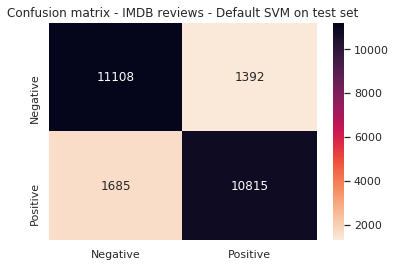

In [0]:
ax = sns.heatmap(df_def_cm, annot=True, fmt='d', cmap=sns.cm.rocket_r, vmin=1300, vmax=11200)
ax.set_title("Confusion matrix - IMDB reviews - Default SVM on test set")
plt.show()

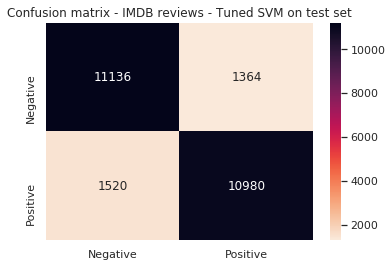

In [0]:
ax = sns.heatmap(df_tun_cm, annot=True, fmt='d', cmap=sns.cm.rocket_r, vmin=1300, vmax=11200)
ax.set_title("Confusion matrix - IMDB reviews - Tuned SVM on test set")
plt.show()

###Ada Boost

In [0]:
from sklearn.ensemble import AdaBoostClassifier

#### 20 news

Reset data to non engineered version


In [0]:
tfidf_vect = TfidfVectorizer()
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
news_X_test = tfidf_vect.transform(newsgroups_test.data)

Default without feature engineering

In [0]:
ab_news_default_no_feat_eng = AdaBoostClassifier()

In [0]:
ab_news_default_no_feat_eng.fit(news_X_train, newsgroups_train.target)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [0]:
ab_news_cv_score_1 = cross_val_score(ab_news_default_no_feat_eng, news_X_train, newsgroups_train.target)

In [0]:
ab_news_cv_score_1.mean()

0.546050620972528

Save the predictions, since we will change how we vectorize the test data for feature engineering - we'll compare the accuracy of these predictions against the feature engineered models in the results section down below


In [0]:
default_no_eng_y_pred = ab_news_default_no_feat_eng.predict(news_X_test)

##### Default DecisionTreeClassifier

Feature selections/reduction

20 newsgroup has an extremely large number of features if we just vectorize it without any constrains: 130107. We aim to reduce the number of features while retaining a descent performance of the model in order to improve training times (training on the entire feature set may yield better results but would explode the training time required to perform hyperparameter tuning)

In [0]:
ab_clf = AdaBoostClassifier(random_state=SEED)

No selection (baseline) default CountVectorizer + TfidfTransformer

In [0]:
print("Number of features:", news_X_train_tfidf.shape[1])

Number of features: 130107


In [0]:
cv_score_min_df = cross_val_score(ab_clf, news_X_train, newsgroups_train.target)
print("CV_score:", cv_score_min_df.mean())

CV_score: 0.546050620972528


min_df=2

In [0]:
tfidf_vect = TfidfVectorizer(min_df=2)
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
print("Number of features:", news_X_train.shape[1])

Number of features: 56436


In [0]:
cv_score_min_df_2 = cross_val_score(ab_clf, news_X_train, newsgroups_train.target)

In [0]:
print("CV_score:", cv_score_min_df_2.mean())

CV_score: 0.546669112501773


min_df=3

In [0]:
tfidf_vect = TfidfVectorizer(min_df=3)
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
print("Number of features:", news_X_train.shape[1])

Number of features: 38869


In [0]:
cv_score_min_df_3 = cross_val_score(ab_clf, news_X_train, newsgroups_train.target)

In [0]:
print("CV_score:", cv_score_min_df_3.mean())

CV_score: 0.5468463769406978


min_df=4

In [0]:
tfidf_vect = TfidfVectorizer(min_df=4)
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
print("Number of features:", news_X_train.shape[1])

Number of features: 30819


In [0]:
cv_score_min_df_4 = cross_val_score(ab_clf, news_X_train, newsgroups_train.target)

In [0]:
print("CV_score:", cv_score_min_df_4.mean())

CV_score: 0.5437519657520571


min_df=.0001

In [0]:
tfidf_vect = TfidfVectorizer(min_df=.001)
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
print("Number of features:", news_X_train.shape[1])

Number of features: 13509


In [0]:
cv_score_min_df_0001 = cross_val_score(ab_clf, news_X_train, newsgroups_train.target)

In [0]:
print("CV_score:", cv_score_min_df_0001.mean())

CV_score: 0.5456974205035217


min_df=.0005

In [0]:
tfidf_vect = TfidfVectorizer(min_df=.0005)
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
print("Number of features:", news_X_train.shape[1])

Number of features: 22707


In [0]:
cv_score_min_df_0005 = cross_val_score(ab_clf, news_X_train, newsgroups_train.target)

In [0]:
print("CV_score:", cv_score_min_df_0005.mean())

CV_score: 0.5448134816306454


min_df=.0001


In [0]:
tfidf_vect = TfidfVectorizer(min_df=.0001)
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
print("Number of features:", news_X_train.shape[1])

Number of features: 56436


In [0]:
cv_score_min_df_0001 = cross_val_score(ab_clf, news_X_train, newsgroups_train.target)

In [0]:
print("CV_score:", cv_score_min_df_0001.mean())

CV_score: 0.546669112501773


We think setting min_df at 3 for 20newsgroup is a descent tradeoff between performance and feature reduction. The number of features gets slashed from 130107 to 38869 while the average CV score is the highest at

Actual default model

In [0]:
ab_news_default = AdaBoostClassifier(random_state=SEED)

In [0]:
tfidf_vect = TfidfVectorizer(min_df=3)
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
news_X_test = tfidf_vect.transform(newsgroups_test.data)

In [0]:
ab_news_default.fit(news_X_train, newsgroups_train.target)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=551)

In [0]:
ab_news_cv_score_2 = cross_val_score(ab_news_default, news_X_train, newsgroups_train.target)

In [0]:
ab_news_cv_score_2.mean()

0.5468463769406978

##### Hyperparameter tuning

Perform Grid Search to find best hyperparameters to train model

In [0]:
ab_gridsearch_parameters = {
    "base_estimator": [DecisionTreeClassifier(max_depth=1, splitter='best', random_state=SEED), DecisionTreeClassifier(max_depth=1, splitter='random', random_state=SEED)],
    "n_estimators": randint(25, 200),
    "learning_rate": uniform(loc=0, scale=1)
}

In [0]:
ab_news_rs = RandomizedSearchCV(ab_clf, ab_gridsearch_parameters, n_iter=10, random_state=SEED, cv=3, n_jobs=-1, verbose=1)

In [0]:
start = time.time()

ab_news_rs.fit(news_X_train, newsgroups_train.target)

print("RandomizedSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.time() - start, len(ab_news_rs.cv_results_['params'])))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  7.9min finished


RandomizedSearchCV took 491.85 seconds for 10 candidate parameter settings.


In [0]:
ab_news_rs.best_estimator_.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=1, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=551, splitter='random'),
 'base_estimator__ccp_alpha': 0.0,
 'base_estimator__class_weight': None,
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': 1,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__presort': 'deprecated',
 'base_estimator__random_state': 55

In [0]:
report(ab_news_rs.cv_results_)

Model with rank: 1
Mean validation score: 0.55286 (std: 0.02263)
Parameters: {'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=551, splitter='random'), 'learning_rate': 0.45728798773747426, 'n_estimators': 141}

Model with rank: 2
Mean validation score: 0.54658 (std: 0.00877)
Parameters: {'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weigh

Tuned model

In [0]:
ab_news_tuned = AdaBoostClassifier(**{'algorithm': 'SAMME.R',
 'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=1, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=551, splitter='random'),
 'learning_rate': 0.45728798773747426,
 'n_estimators': 141,
 'random_state': 551})

In [0]:
ab_news_tuned.fit(news_X_train, newsgroups_train.target)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [0]:
ab_news_cv_score_3 = cross_val_score(ab_news_tuned, news_X_train, newsgroups_train.target)

In [0]:
ab_news_cv_score_3.mean()

0.5854698249977632

##### Results

Now we compare the default model and the tuned model on the test set

In [0]:
default_y_pred = ab_news_default.predict(news_X_test)

In [0]:
tuned_y_pred = ab_news_tuned.predict(news_X_test)

In [0]:
default_no_eng_acc = metrics.accuracy_score(newsgroups_test.target, default_no_eng_y_pred)

In [0]:
default_acc = metrics.accuracy_score(newsgroups_test.target, default_y_pred)

In [0]:
tuned_acc = metrics.accuracy_score(newsgroups_test.target, tuned_y_pred)

In [0]:
print("Validation Accuracy")
print("Default model w/o feat. eng.:\t", ab_news_cv_score_1.mean())
print("Default model w/ feat. eng.:\t", ab_news_cv_score_2.mean())
print("Tuned model w/ feat. eng.:\t", ab_news_cv_score_3.mean())

Validation Accuracy
Default model w/o feat. eng.:	 0.546050620972528
Default model w/ feat. eng.:	 0.5468463769406978
Tuned model w/ feat. eng.:	 0.5854698249977632


In [0]:
print("Test Accuracy")
print("Default model w/o feat. eng.:\t", default_no_eng_acc)
print("Default model w/ feat. eng.:\t", default_acc)
print("Tuned model w/ feat. eng.:\t", tuned_acc)

Test Accuracy
Default model w/o feat. eng.:	 0.5087626128518322
Default model w/ feat. eng.:	 0.5168613913967074
Tuned model w/ feat. eng.:	 0.5480616038236856


Save test accuracies for plot later

In [0]:
ab_news_test_acc_1 = default_no_eng_acc
ab_news_test_acc_2 = default_acc
ab_news_test_acc_3 = tuned_acc

In [0]:
default_cm = metrics.confusion_matrix(newsgroups_test.target, default_y_pred)
tuned_cm = metrics.confusion_matrix(newsgroups_test.target, tuned_y_pred)

In [0]:
df_def_cm = pd.DataFrame(default_cm, newsgroups_train.target_names, newsgroups_train.target_names)
df_tun_cm = pd.DataFrame(tuned_cm, newsgroups_train.target_names, newsgroups_train.target_names)

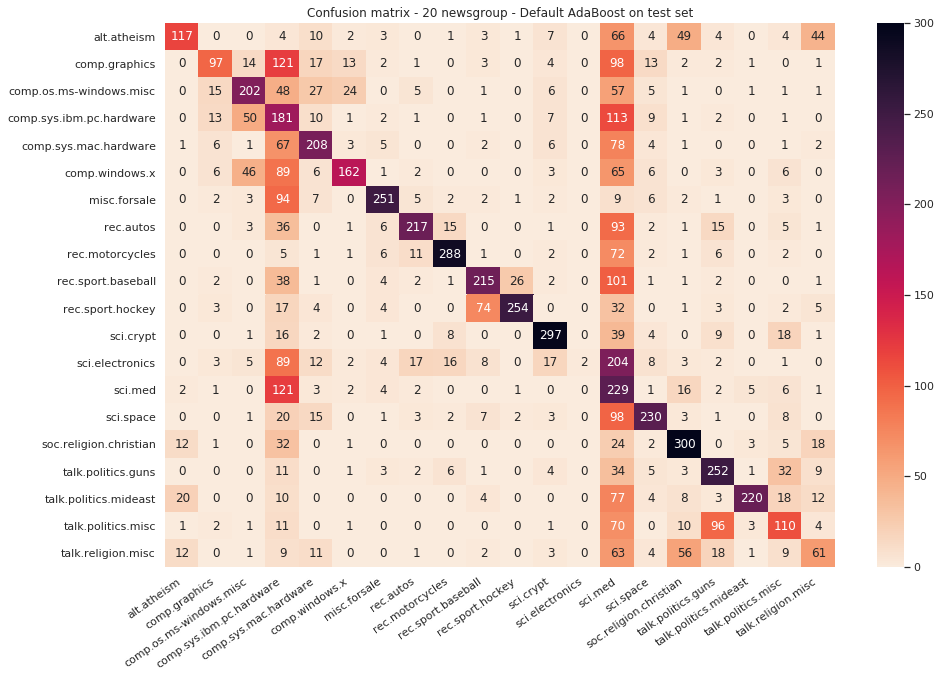

In [0]:
plt.figure(figsize = (15,10))
ax = sns.heatmap(df_def_cm, annot=True, fmt='d', cmap=sns.cm.rocket_r, vmin=0, vmax=300)
ax.set_title("Confusion matrix - 20 newsgroup - Default AdaBoost on test set")
ax.set_xticklabels(ax.get_xticklabels(),rotation=35, horizontalalignment='right')
plt.show()

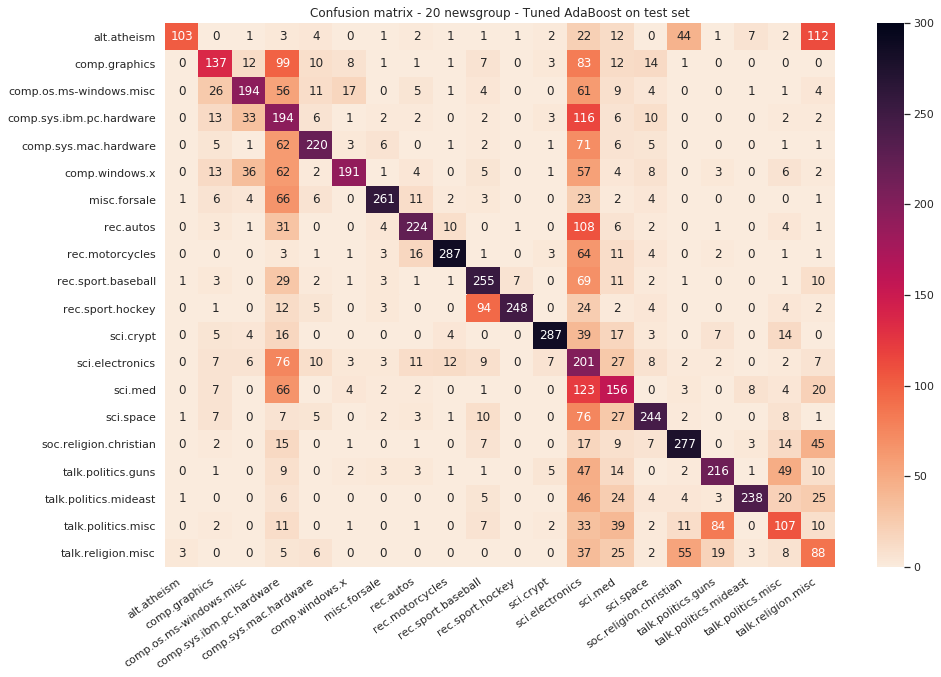

In [0]:
plt.figure(figsize = (15,10))
ax = sns.heatmap(df_tun_cm, annot=True, fmt='d', cmap=sns.cm.rocket_r, vmin=0, vmax=300)
ax.set_title("Confusion matrix - 20 newsgroup - Tuned AdaBoost on test set")
ax.set_xticklabels(ax.get_xticklabels(),rotation=35, horizontalalignment='right')
plt.show()

#### IMDB reviews

Reset data to non engineered version


In [0]:
tfidf_vect = TfidfVectorizer()
imdb_X_train_tfidf = tfidf_vect.fit_transform(imdb_X_train)
imdb_X_test_tfidf = tfidf_vect.transform(imdb_X_test)

Default without feature engineering

In [0]:
ab_imdb_default_no_feat_eng = AdaBoostClassifier(random_state=SEED)

In [0]:
ab_imdb_default_no_feat_eng.fit(imdb_X_train_tfidf, imdb_y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=551)

In [0]:
ab_imdb_cv_score_1 = cross_val_score(ab_imdb_default_no_feat_eng, imdb_X_train_tfidf, imdb_y_train)

In [0]:
ab_imdb_cv_score_1.mean()

0.80324

Save the predictions, since we will change how we vectorize the test data for feature engineering - we'll compare the accuracy of these predictions against the feature engineered models in the results section down below


In [0]:
default_no_eng_y_pred = ab_imdb_default_no_feat_eng.predict(imdb_X_test_tfidf)

##### Default DecisionTreeClassifier

Feature selections/reduction

In [0]:
ab_clf = AdaBoostClassifier(random_state=SEED)

No selection (baseline)

In [0]:
print("Number of features:", imdb_X_train_tfidf.shape[1])

Number of features: 74843


In [0]:
cv_score_min_df = cross_val_score(ab_clf, imdb_X_train_tfidf, imdb_y_train)
print("CV_score:", cv_score_min_df.mean())

CV_score: 0.80324


min_df=2

In [0]:
tfidf_vect = TfidfVectorizer(min_df=2)
imdb_X_train_tfidf = tfidf_vect.fit_transform(imdb_X_train)
print("Number of features:", imdb_X_train_tfidf.shape[1])

Number of features: 44796


In [0]:
cv_score_min_df_2 = cross_val_score(ab_clf, imdb_X_train_tfidf, imdb_y_train)

In [0]:
print("CV_score:", cv_score_min_df_2.mean())

CV_score: 0.8058400000000001


min_df=3

In [0]:
tfidf_vect = TfidfVectorizer(min_df=3)
imdb_X_train_tfidf = tfidf_vect.fit_transform(imdb_X_train)
print("Number of features:", imdb_X_train_tfidf.shape[1])

Number of features: 35852


In [0]:
cv_score_min_df_3 = cross_val_score(ab_clf, imdb_X_train_tfidf, imdb_y_train)

In [0]:
print("CV_score:", cv_score_min_df_3.mean())

CV_score: 0.8046


min_df=4

In [0]:
tfidf_vect = TfidfVectorizer(min_df=4)
imdb_X_train_tfidf = tfidf_vect.fit_transform(imdb_X_train)
print("Number of features:", imdb_X_train_tfidf.shape[1])

Number of features: 30768


In [0]:
cv_score_min_df_4 = cross_val_score(ab_clf, imdb_X_train_tfidf, imdb_y_train)

In [0]:
print("CV_score:", cv_score_min_df_4.mean())

CV_score: 0.8037600000000001


min_df=.0001

In [0]:
tfidf_vect = TfidfVectorizer(min_df=.001)
imdb_X_train_tfidf = tfidf_vect.fit_transform(imdb_X_train)
print("Number of features:", imdb_X_train_tfidf.shape[1])

Number of features: 10455


In [0]:
cv_score_min_df_0001 = cross_val_score(ab_clf, imdb_X_train_tfidf, imdb_y_train)

In [0]:
print("CV_score:", cv_score_min_df_0001.mean())

CV_score: 0.8029999999999999


We think setting min_df at 2 for IMDB reviews is a descent tradeoff between performance and feature reduction. The number of features gets reduced while the average CV score is at 0.80584 (highest)

Actual decision tree classifier

In [0]:
ab_imdb_default = AdaBoostClassifier(random_state=SEED)

In [0]:
tfidf_vect = TfidfVectorizer(min_df=2)
imdb_X_train_tfidf = tfidf_vect.fit_transform(imdb_X_train)
imdb_X_test_tfidf = tfidf_vect.transform(imdb_X_test)

In [0]:
ab_imdb_default.fit(imdb_X_train_tfidf, imdb_y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=551)

In [0]:
ab_imdb_cv_score_2 = cross_val_score(ab_imdb_default, imdb_X_train_tfidf, imdb_y_train)

In [0]:
ab_imdb_cv_score_2.mean()

0.8058400000000001

##### Hyperparameter tuning

Perform Grid Search to find best hyperparameters to train model

In [0]:
ab_gridsearch_parameters = {
    "base_estimator": [DecisionTreeClassifier(max_depth=1, splitter='best', random_state=SEED), DecisionTreeClassifier(max_depth=1, splitter='random', random_state=SEED)],
    "n_estimators": randint(25, 200),
    "learning_rate": uniform(loc=0, scale=1)
}

In [0]:
ab_imdb_rs = RandomizedSearchCV(ab_clf, ab_gridsearch_parameters, n_iter=10, random_state=SEED, cv=3, n_jobs=-1, verbose=1)

In [0]:
start = time.time()

ab_imdb_rs.fit(imdb_X_train_tfidf, imdb_y_train)

print("RandomizedSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.time() - start, len(ab_imdb_rs.cv_results_['params'])))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 16.5min finished


RandomizedSearchCV took 1074.45 seconds for 10 candidate parameter settings.


In [0]:
ab_imdb_rs.best_estimator_.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=1, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=551, splitter='best'),
 'base_estimator__ccp_alpha': 0.0,
 'base_estimator__class_weight': None,
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': 1,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__presort': 'deprecated',
 'base_estimator__random_state': 551,

In [0]:
report(ab_imdb_rs.cv_results_)

Model with rank: 1
Mean validation score: 0.83984 (std: 0.00308)
Parameters: {'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=551, splitter='best'), 'learning_rate': 0.7219079725144202, 'n_estimators': 145}

Model with rank: 2
Mean validation score: 0.83520 (std: 0.00294)
Parameters: {'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_f

Tuned model

In [0]:
ab_imdb_tuned = AdaBoostClassifier(**{'algorithm': 'SAMME.R',
 'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=1, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=551, splitter='best'),
 'learning_rate': 0.7219079725144202,
 'n_estimators': 145,
 'random_state': 551})

In [0]:
ab_imdb_tuned.fit(imdb_X_train_tfidf, imdb_y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [0]:
ab_imdb_cv_score_3 = cross_val_score(ab_imdb_tuned, imdb_X_train_tfidf, imdb_y_train)

In [0]:
ab_imdb_cv_score_3.mean()

0.84092

##### Results

Now we compare the default model and the tuned model on the test set

In [0]:
default_y_pred = ab_imdb_default.predict(imdb_X_test_tfidf)

In [0]:
tuned_y_pred = ab_imdb_tuned.predict(imdb_X_test_tfidf)

In [0]:
default_no_eng_acc = metrics.accuracy_score(imdb_y_test, default_no_eng_y_pred)

In [0]:
default_acc = metrics.accuracy_score(imdb_y_test, default_y_pred)

In [0]:
tuned_acc = metrics.accuracy_score(imdb_y_test, tuned_y_pred)

In [0]:
print("Validation Accuracy")
print("Default model w/o feat. eng.:\t", ab_imdb_cv_score_1.mean())
print("Default model w/ feat. eng.:\t", ab_imdb_cv_score_2.mean())
print("Tuned model w/ feat. eng.:\t", ab_imdb_cv_score_3.mean())

Validation Accuracy
Default model w/o feat. eng.:	 0.80324
Default model w/ feat. eng.:	 0.8058400000000001
Tuned model w/ feat. eng.:	 0.84092


In [0]:
print("Test Accuracy")
print("Default model w/o feat. eng.:\t", default_no_eng_acc)
print("Default model w/ feat. eng.:\t", default_acc)
print("Tuned model w/ feat. eng.:\t", tuned_acc)

Test Accuracy
Default model w/o feat. eng.:	 0.80296
Default model w/ feat. eng.:	 0.8032
Tuned model w/ feat. eng.:	 0.84248


Save test accuracies for plot later

In [0]:
ab_imdb_test_acc_1 = default_no_eng_acc
ab_imdb_test_acc_2 = default_acc
ab_imdb_test_acc_3 = tuned_acc

In [0]:
default_cm = metrics.confusion_matrix(imdb_y_test, default_y_pred)
tuned_cm = metrics.confusion_matrix(imdb_y_test, tuned_y_pred)

In [0]:
df_def_cm = pd.DataFrame(default_cm, ['Negative', 'Positive'], ['Negative', 'Positive'])
df_tun_cm = pd.DataFrame(tuned_cm, ['Negative', 'Positive'], ['Negative', 'Positive'])

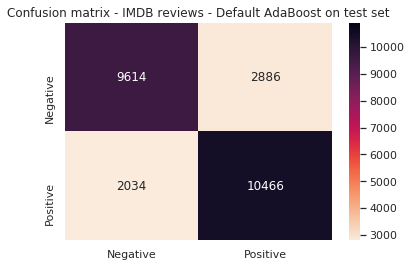

In [0]:
ax = sns.heatmap(df_def_cm, annot=True, fmt='d', cmap=sns.cm.rocket_r, vmin=2800, vmax=10900)
ax.set_title("Confusion matrix - IMDB reviews - Default AdaBoost on test set")
plt.show()

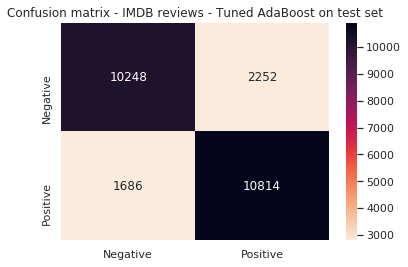

In [0]:
ax = sns.heatmap(df_tun_cm, annot=True, fmt='d', cmap=sns.cm.rocket_r, vmin=2800, vmax=10900)
ax.set_title("Confusion matrix - IMDB reviews - Tuned AdaBoost on test set")
plt.show()

### Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

#### 20 news

Reset data to non engineered version


In [0]:
tfidf_vect = TfidfVectorizer()
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
news_X_test = tfidf_vect.transform(newsgroups_test.data)

Default without feature engineering

In [0]:
rf_news_default_no_feat_eng = RandomForestClassifier(random_state=SEED)

In [0]:
rf_news_default_no_feat_eng.fit(news_X_train, newsgroups_train.target)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=551,
                       verbose=0, warm_start=False)

In [0]:
rf_news_cv_score_1 = cross_val_score(rf_news_default_no_feat_eng, news_X_train, newsgroups_train.target)

In [0]:
rf_news_cv_score_1.mean()

0.83507214236792

Save the predictions, since we will change how we vectorize the test data for feature engineering - we'll compare the accuracy of these predictions against the feature engineered models in the results section down below


In [0]:
default_no_eng_y_pred = rf_news_default_no_feat_eng.predict(news_X_test)

##### Default DecisionTreeClassifier

Feature selections/reduction

20 newsgroup has an extremely large number of features if we just vectorize it without any constraints: 130107. We aim to reduce the number of features while retaining a descent performance of the model in order to improve training times (training on the entire feature set may yield better results but would explode the training time required to perform hyperparameter tuning)

In [0]:
rf_clf = RandomForestClassifier(random_state=SEED)

No selection (baseline) default CountVectorizer + TfidfTransformer

In [0]:
print("Number of features:", news_X_train_tfidf.shape[1])

Number of features: 130107


In [0]:
cv_score_min_df = cross_val_score(rf_clf, news_X_train_tfidf, newsgroups_train.target)
print("CV_score:", cv_score_min_df.mean())

CV_score: 0.83507214236792


min_df=2

In [0]:
tfidf_vect = TfidfVectorizer(min_df=2)
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
print("Number of features:", news_X_train.shape[1])

Number of features: 56436


In [0]:
cv_score_min_df_2 = cross_val_score(rf_clf, news_X_train, newsgroups_train.target)

In [0]:
print("CV_score:", cv_score_min_df_2.mean())

CV_score: 0.8314479695466179


min_df=3

In [0]:
tfidf_vect = TfidfVectorizer(min_df=3)
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
print("Number of features:", news_X_train.shape[1])

Number of features: 38869


In [0]:
cv_score_min_df_3 = cross_val_score(rf_clf, news_X_train, newsgroups_train.target)

In [0]:
print("CV_score:", cv_score_min_df_3.mean())

CV_score: 0.8331276643876642


min_df=4

In [0]:
tfidf_vect = TfidfVectorizer(min_df=4)
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
print("Number of features:", news_X_train.shape[1])

Number of features: 30819


In [0]:
cv_score_min_df_4 = cross_val_score(rf_clf, news_X_train, newsgroups_train.target)

In [0]:
print("CV_score:", cv_score_min_df_4.mean())

CV_score: 0.8319782391003077


min_df=.0001

In [0]:
tfidf_vect = TfidfVectorizer(min_df=.001)
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
print("Number of features:", news_X_train.shape[1])

Number of features: 13509


In [0]:
cv_score_min_df_0001 = cross_val_score(rf_clf, news_X_train, newsgroups_train.target)

In [0]:
print("CV_score:", cv_score_min_df_0001.mean())

CV_score: 0.8238472048519743


min_df=.0005

In [0]:
tfidf_vect = TfidfVectorizer(min_df=.0005)
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
print("Number of features:", news_X_train.shape[1])

Number of features: 22707


In [0]:
cv_score_min_df_0005 = cross_val_score(rf_clf, news_X_train, newsgroups_train.target)

In [0]:
print("CV_score:", cv_score_min_df_0005.mean())

CV_score: 0.8280005532432126


min_df=.0001


In [0]:
fidf_vect = TfidfVectorizer(min_df=.0001)
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
print("Number of features:", news_X_train.shape[1])

Number of features: 22707


In [0]:
cv_score_min_df_0001 = cross_val_score(rf_clf, news_X_train, newsgroups_train.target)

In [0]:
print("CV_score:", cv_score_min_df_0001.mean())

CV_score: 0.8280005532432126


We think setting min_df at 3 for 20newsgroup is a descent tradeoff between performance and feature reduction. The number of features gets slashed from 130107 to 38869 while the average CV score is only decreased by ~0.0019

Actual default model

In [0]:
rf_news_default = RandomForestClassifier(random_state=SEED)

In [0]:
tfidf_vect = TfidfVectorizer(min_df=3)
news_X_train = tfidf_vect.fit_transform(newsgroups_train.data)
news_X_test = tfidf_vect.transform(newsgroups_test.data)

In [0]:
rf_news_default.fit(news_X_train, newsgroups_train.target)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=551,
                       verbose=0, warm_start=False)

In [0]:
rf_news_cv_score_2 = cross_val_score(rf_news_default, news_X_train, newsgroups_train.target)

In [0]:
rf_news_cv_score_2.mean()

0.8331276643876642

##### Hyperparameter tuning

Perform Grid Search to find best hyperparameters to train model

In [0]:
rf_gridsearch_parameters = {
  'bootstrap': [True, False],
  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
  'max_features': ['auto', 'sqrt'],
  'min_samples_leaf': [1, 2, 4],
  'min_samples_split': [2, 5, 10],
  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}

In [0]:
rf_news_rs = RandomizedSearchCV(rf_clf, rf_gridsearch_parameters, n_iter=5, random_state=SEED, cv=3, n_jobs=-1, verbose=5)

In [0]:
start = time.time()

rf_news_rs.fit(news_X_train, newsgroups_train.target)

print("RandomizedSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.time() - start, len(rf_news_rs.cv_results_['params'])))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 30.7min finished


RandomizedSearchCV took 2134.23 seconds for 5 candidate parameter settings.


In [0]:
rf_news_rs.best_estimator_.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 60,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1600,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 551,
 'verbose': 0,
 'warm_start': False}

In [0]:
report(rf_news_rs.cv_results_)

Model with rank: 1
Mean validation score: 0.84011 (std: 0.00296)
Parameters: {'n_estimators': 1600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': False}

Model with rank: 2
Mean validation score: 0.83799 (std: 0.00373)
Parameters: {'n_estimators': 800, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': False}

Model with rank: 3
Mean validation score: 0.83587 (std: 0.00547)
Parameters: {'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': False}

Model with rank: 4
Mean validation score: 0.81147 (std: 0.00486)
Parameters: {'n_estimators': 1800, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': False}

Model with rank: 5
Mean validation score: 0.78345 (std: 0.00574)
Parameters: {'n_estimators': 1800, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 

Tuned model

In [0]:
rf_news_tuned = RandomForestClassifier(**
{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 60,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1600,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 551,
 'verbose': 0,
 'warm_start': False})

In [0]:
rf_news_tuned.fit(news_X_train, newsgroups_train.target)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=60, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1600,
                       n_jobs=None, oob_score=False, random_state=551,
                       verbose=0, warm_start=False)

In [0]:
rf_news_cv_score_3 = cross_val_score(rf_news_tuned, news_X_train, newsgroups_train.target)

In [0]:
rf_news_cv_score_3.mean()

0.8477997056402286

##### Results

In [0]:
default_y_pred = rf_news_default.predict(news_X_test)

In [0]:
tuned_y_pred = rf_news_tuned.predict(news_X_test)

In [0]:
default_no_eng_acc = metrics.accuracy_score(newsgroups_test.target, default_no_eng_y_pred)

In [0]:
default_acc = metrics.accuracy_score(newsgroups_test.target, default_y_pred)

In [0]:
tuned_acc = metrics.accuracy_score(newsgroups_test.target, tuned_y_pred)

In [0]:
print("Validation Accuracy")
print("Default model w/o feat. eng.:\t", rf_news_cv_score_1.mean())
print("Default model w/ feat. eng.:\t", rf_news_cv_score_2.mean())
print("Tuned model w/ feat. eng.:\t", rf_news_cv_score_3.mean())

Validation Accuracy
Default model w/o feat. eng.:	 0.83507214236792
Default model w/ feat. eng.:	 0.8331276643876642
Tuned model w/ feat. eng.:	 0.8477997056402286


In [0]:
print("Test Accuracy")
print("Default model w/o feat. eng.:\t", default_no_eng_acc)
print("Default model w/ feat. eng.:\t", default_acc)
print("Tuned model w/ feat. eng.:\t", tuned_acc)

Test Accuracy
Default model w/o feat. eng.:	 0.7612851832182688
Default model w/ feat. eng.:	 0.7535847052575677
Tuned model w/ feat. eng.:	 0.7758895379713223


Save test accuracies for plot later

In [0]:
rf_news_test_acc_1 = default_no_eng_acc
rf_news_test_acc_2 = default_acc
rf_news_test_acc_3 = tuned_acc

Now we compare the default model and the tuned model on the test set

In [0]:
default_cm = metrics.confusion_matrix(newsgroups_test.target, default_y_pred)
tuned_cm = metrics.confusion_matrix(newsgroups_test.target, tuned_y_pred)

In [0]:
df_def_cm = pd.DataFrame(default_cm, newsgroups_train.target_names, newsgroups_train.target_names)
df_tun_cm = pd.DataFrame(tuned_cm, newsgroups_train.target_names, newsgroups_train.target_names)

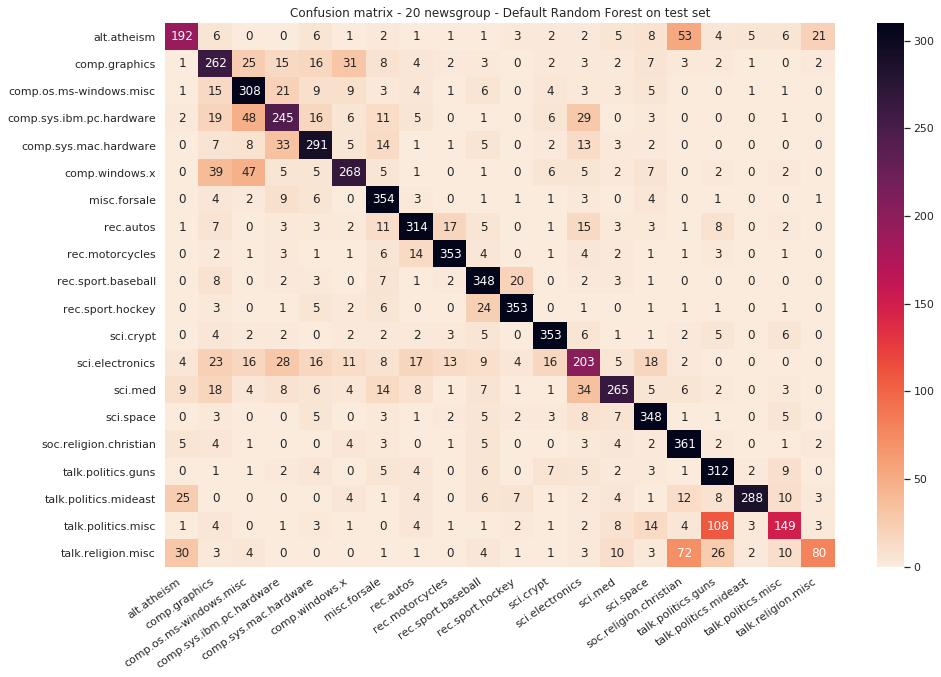

In [0]:
plt.figure(figsize = (15,10))
ax = sns.heatmap(df_def_cm, annot=True, fmt='d', cmap=sns.cm.rocket_r, vmin=0, vmax=310)
ax.set_title("Confusion matrix - 20 newsgroup - Default Random Forest on test set")
ax.set_xticklabels(ax.get_xticklabels(),rotation=35, horizontalalignment='right')
plt.show()

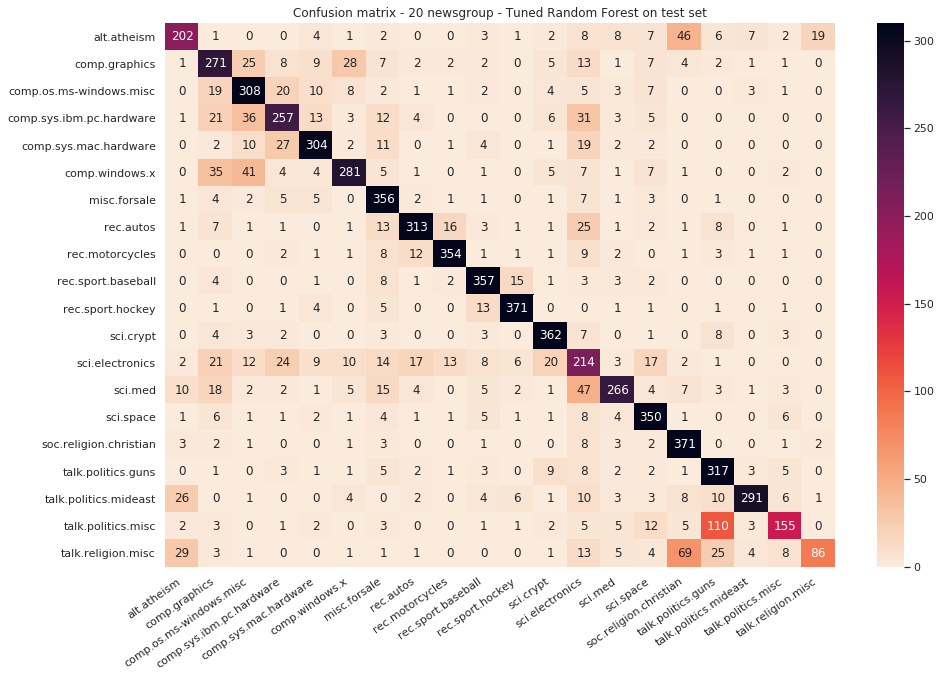

In [0]:
plt.figure(figsize = (15,10))
ax = sns.heatmap(df_tun_cm, annot=True, fmt='d', cmap=sns.cm.rocket_r, vmin=0, vmax=310)
ax.set_title("Confusion matrix - 20 newsgroup - Tuned Random Forest on test set")
ax.set_xticklabels(ax.get_xticklabels(),rotation=35, horizontalalignment='right')
plt.show()

#### IMDB reviews

Reset data to non engineered version


In [0]:
tfidf_vect = TfidfVectorizer()
imdb_X_train_tfidf = tfidf_vect.fit_transform(imdb_X_train)
imdb_X_test_tfidf = tfidf_vect.transform(imdb_X_test)

Default without feature engineering

In [0]:
rf_imdb_default_no_feat_eng = RandomForestClassifier(random_state=SEED)

In [0]:
rf_imdb_default_no_feat_eng.fit(imdb_X_train_tfidf, imdb_y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=551,
                       verbose=0, warm_start=False)

In [0]:
rf_imdb_cv_score_1 = cross_val_score(rf_imdb_default_no_feat_eng, imdb_X_train_tfidf, imdb_y_train)

In [0]:
rf_imdb_cv_score_1.mean()

0.8354799999999999

Save the predictions, since we will change how we vectorize the train/test data for feature engineering - we'll compare the accuracy of these predictions against the feature engineered models in the Results section down below

In [0]:
default_no_eng_y_pred = rf_imdb_default_no_feat_eng.predict(imdb_X_test_tfidf)

##### Default DecisionTreeClassifier

Feature selections/reduction

In [0]:
rf_clf = RandomForestClassifier(random_state=SEED)

No selection (baseline)

In [0]:
print("Number of features:", imdb_X_train_tfidf.shape[1])

Number of features: 74843


In [0]:
cv_score_min_df = cross_val_score(rf_clf, imdb_X_train_tfidf, imdb_y_train)
print("CV_score:", cv_score_min_df.mean())

CV_score: 0.8354799999999999


min_df=2

In [0]:
tfidf_vect = TfidfVectorizer(min_df=2)
imdb_X_train_tfidf = tfidf_vect.fit_transform(imdb_X_train)
print("Number of features:", imdb_X_train_tfidf.shape[1])

Number of features: 44796


In [0]:
cv_score_min_df_2 = cross_val_score(rf_clf, imdb_X_train_tfidf, imdb_y_train)

In [0]:
print("CV_score:", cv_score_min_df_2.mean())

CV_score: 0.8358399999999999


min_df=3

In [0]:
tfidf_vect = TfidfVectorizer(min_df=3)
imdb_X_train_tfidf = tfidf_vect.fit_transform(imdb_X_train)
print("Number of features:", imdb_X_train_tfidf.shape[1])

Number of features: 35852


In [0]:
cv_score_min_df_3 = cross_val_score(rf_clf, imdb_X_train_tfidf, imdb_y_train)

In [0]:
print("CV_score:", cv_score_min_df_3.mean())

CV_score: 0.83388


min_df=4

In [0]:
tfidf_vect = TfidfVectorizer(min_df=4)
imdb_X_train_tfidf = tfidf_vect.fit_transform(imdb_X_train)
print("Number of features:", imdb_X_train_tfidf.shape[1])

Number of features: 30768


In [0]:
cv_score_min_df_4 = cross_val_score(rf_clf, imdb_X_train_tfidf, imdb_y_train)

In [0]:
print("CV_score:", cv_score_min_df_4.mean())

CV_score: 0.83804


min_df=.0001

In [0]:
tfidf_vect = TfidfVectorizer(min_df=.001)
imdb_X_train_tfidf = tfidf_vect.fit_transform(imdb_X_train)
print("Number of features:", imdb_X_train_tfidf.shape[1])

Number of features: 10455


In [0]:
cv_score_min_df_0001 = cross_val_score(rf_clf, imdb_X_train_tfidf, imdb_y_train)

In [0]:
print("CV_score:", cv_score_min_df_0001.mean())

CV_score: 0.8394


We think setting min_df at .001 for IMDB reviews is a descent tradeoff between performance and feature reduction. The number of features gets reduced while the average CV score is the highest at 0.8394.

Actual decision tree classifier

In [0]:
rf_imdb_default = RandomForestClassifier(random_state=SEED)

In [0]:
tfidf_vect = TfidfVectorizer(min_df=.001)
imdb_X_train_tfidf = tfidf_vect.fit_transform(imdb_X_train)
imdb_X_test_tfidf = tfidf_vect.transform(imdb_X_test)

In [0]:
rf_imdb_default.fit(imdb_X_train_tfidf, imdb_y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=551,
                       verbose=0, warm_start=False)

In [0]:
rf_imdb_cv_score_2 = cross_val_score(rf_imdb_default, imdb_X_train_tfidf, imdb_y_train)

In [0]:
rf_imdb_cv_score_2.mean()

0.8394

##### Hyperparameter tuning

Perform Grid Search to find best hyperparameters to train model

In [0]:
rf_gridsearch_parameters = {
  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
  'min_samples_leaf': [1, 2, 4],
  'min_samples_split': [2, 5, 10],
  'n_estimators': [100, 200, 300]
}

In [0]:
rf_imdb_rs = RandomizedSearchCV(rf_clf, rf_gridsearch_parameters, n_iter=3, random_state=SEED, cv=2, n_jobs=-1, verbose=1)

In [0]:
start = time.time()

rf_imdb_rs.fit(imdb_X_train_tfidf, imdb_y_train)

print("RandomizedSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.time() - start, len(rf_imdb_rs.cv_results_['params'])))

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  3.2min finished


RandomizedSearchCV took 362.16 seconds for 3 candidate parameter settings.


In [0]:
rf_imdb_rs.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 90,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 551,
 'verbose': 0,
 'warm_start': False}

In [0]:
report(rf_imdb_rs.cv_results_)

Model with rank: 1
Mean validation score: 0.84596 (std: 0.00180)
Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 90}

Model with rank: 2
Mean validation score: 0.84224 (std: 0.00088)
Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 80}

Model with rank: 3
Mean validation score: 0.84024 (std: 0.00224)
Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 90}



Tuned model

In [0]:
# rf_imdb_tuned = RandomForestClassifier(**{'bootstrap': True,
#  'ccp_alpha': 0.0,
#  'class_weight': None,
#  'criterion': 'gini',
#  'max_depth': 50,
#  'max_features': 'auto',
#  'max_leaf_nodes': None,
#  'max_samples': None,
#  'min_impurity_decrease': 0.0,
#  'min_impurity_split': None,
#  'min_samples_leaf': 4,
#  'min_samples_split': 10,
#  'min_weight_fraction_leaf': 0.0,
#  'n_estimators': 200,
#  'n_jobs': None,
#  'oob_score': False,
#  'random_state': 551,
#  'verbose': 0,
#  'warm_start': False})

rf_imdb_tuned = RandomForestClassifier(**{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 90,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 551,
 'verbose': 0,
 'warm_start': False})

In [0]:
rf_imdb_tuned.fit(imdb_X_train_tfidf, imdb_y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=90, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=551,
                       verbose=0, warm_start=False)

In [0]:
rf_imdb_cv_score_3 = cross_val_score(rf_imdb_tuned, imdb_X_train_tfidf, imdb_y_train)

In [0]:
rf_imdb_cv_score_3.mean()

0.8480399999999999

##### Results

Now we compare the default model and the tuned model on the test set

In [0]:
default_y_pred = rf_imdb_default.predict(imdb_X_test_tfidf)

In [0]:
tuned_y_pred = rf_imdb_tuned.predict(imdb_X_test_tfidf)

In [0]:
default_no_eng_acc = metrics.accuracy_score(imdb_y_test, default_no_eng_y_pred)

In [0]:
default_acc = metrics.accuracy_score(imdb_y_test, default_y_pred)

In [0]:
tuned_acc = metrics.accuracy_score(imdb_y_test, tuned_y_pred)

In [0]:
print("Validation Accuracy")
print("Default model w/o feat. eng.:\t", rf_imdb_cv_score_1.mean())
print("Default model w/ feat. eng.:\t", rf_imdb_cv_score_2.mean())
print("Tuned model w/ feat. eng.:\t", rf_imdb_cv_score_3.mean())

Validation Accuracy
Default model w/o feat. eng.:	 0.8354799999999999
Default model w/ feat. eng.:	 0.8394
Tuned model w/ feat. eng.:	 0.8480399999999999


In [0]:
print("Test Accuracy")
print("Default model w/o feat. eng.:\t", default_no_eng_acc)
print("Default model w/ feat. eng.:\t", default_acc)
print("Tuned model w/ feat. eng.:\t", tuned_acc)

Test Accuracy
Default model w/o feat. eng.:	 0.83752
Default model w/ feat. eng.:	 0.84264
Tuned model w/ feat. eng.:	 0.85136


Save test accuracies for plot later

In [0]:
rf_imdb_test_acc_1 = default_no_eng_acc
rf_imdb_test_acc_2 = default_acc
rf_imdb_test_acc_3 = tuned_acc

In [0]:
default_cm = metrics.confusion_matrix(imdb_y_test, default_y_pred)
tuned_cm = metrics.confusion_matrix(imdb_y_test, tuned_y_pred)

In [0]:
df_def_cm = pd.DataFrame(default_cm, ['Negative', 'Positive'], ['Negative', 'Positive'])
df_tun_cm = pd.DataFrame(tuned_cm, ['Negative', 'Positive'], ['Negative', 'Positive'])

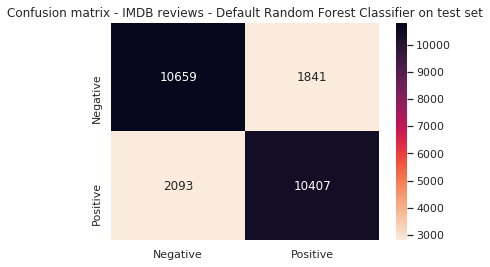

In [0]:
ax = sns.heatmap(df_def_cm, annot=True, fmt='d', cmap=sns.cm.rocket_r, vmin=2800, vmax=10800)
ax.set_title("Confusion matrix - IMDB reviews - Default Random Forest Classifier on test set")
plt.show()

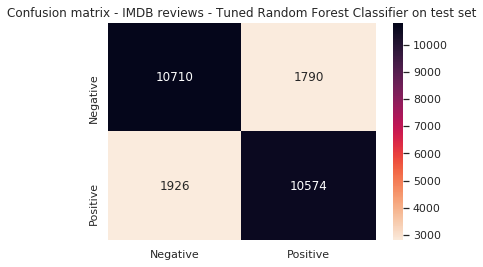

In [0]:
ax = sns.heatmap(df_tun_cm, annot=True, fmt='d', cmap=sns.cm.rocket_r, vmin=2800, vmax=10800)
ax.set_title("Confusion matrix - IMDB reviews - Tuned Random Forest Classifier on test set")
plt.show()

### Overall accuracy

In [0]:
np.mean(np.concatenate([twenty_news_pred,imdb_pred])==np.concatenate([newsgroups_test.target,imdb_y_test]))

0.8773515308004426